# King County Housing with Linear Regression

### By: Eric Romano, Christian Moya

## Notebook 3: Modeling

In [1]:
# for webscraping
import os 
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time 
import sys
import numpy as np
import pandas as pd 
import regex as re 
import requests
import lxml
from lxml.html.soupparser import fromstring
import prettify
import numbers 
import htmltext

# for visuals using geopandas
from shapely.geometry import Point, Polygon 
import geopandas as gpd
import descartes
import haversine as hs
import folium

# for plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import norm 
import scipy.stats as stats
from matplotlib.font_manager import FontProperties
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import tilemapbase
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
import adjustText as aT
import shapely.speedups
shapely.speedups.enable()

# for stats (min,max,mean)
import statistics
from numpy import mean
from numpy import std 

# statsmodel
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor


# sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [29]:
df = pd.read_csv('data_pred5.csv')
df_norm = pd.read_csv('df_norm_final')
df_quantile = pd.read_csv('df_processed_quantile')

# Model 1

In this first model I will explore the orginal features that account for the homes that were sold within the years 2014 and 2015. Due to the objective of the buisness problem being solve we targeted only homes that fall within 1.5 standard deviation of the price mean. This decision was made when evaluating the median house hold income in 2015, which was about 81,000. 


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 30 columns):
price                           18109 non-null float64
bathrooms                       18109 non-null float64
sqft_lot                        18109 non-null int64
sqft_living                     18109 non-null int64
waterfront                      18109 non-null float64
grade                           18109 non-null int64
zipcode                         18109 non-null int64
lat                             18109 non-null float64
long                            18109 non-null float64
district                        18109 non-null object
grades                          18109 non-null object
grade_rank                      18109 non-null int64
coor                            18109 non-null object
School_K_12                     18109 non-null float64
School_Junior_High_Middle       18109 non-null float64
School_Elementary               18109 non-null float64
dist_School_High        

When examining the initial dataset I dove deeper to understand the relationship between all the columns to price. I have determined the following columns have the strongest relationship to price so I will use these to establish my first model using the following features. 

1. bathrooms
2. sqft_lot
3. sqft_living
5. waterfront
4. grade

In [6]:
target_value1 = ['price','bathrooms','sqft_lot','sqft_living','waterfront','grade']

In [7]:
df_model1 = df[target_value1]

In [8]:
df_model1

price  bathrooms  sqft_lot  sqft_living  waterfront  grade
0      538000.0       2.25      7242         2570         0.0      7
1      180000.0       1.00     10000          770         0.0      6
2      604000.0       3.00      5000         1960         0.0      7
3      510000.0       2.00      8080         1680         0.0      8
4      257500.0       2.25      6819         1715         0.0      7
...         ...        ...       ...          ...         ...    ...
18104  475000.0       2.50      1294         1310         0.0      8
18105  360000.0       2.50      1131         1530         0.0      8
18106  400000.0       2.50      5813         2310         0.0      8
18107  402101.0       0.75      1350         1020         0.0      7
18108  325000.0       0.75      1076         1020         0.0      7

[18109 rows x 6 columns]

In [9]:
# Creating dummy variables for my categorical variables
waterfront_dummy = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
grade_dummy = pd.get_dummies(df.grade, prefix='grade', drop_first=True)

# add these new dummy variables into the df
df_model1 = pd.concat([df_model1, waterfront_dummy, grade_dummy], axis=1)
# delete the categorical variables, they are already being represented by the dummy variables
df_model1= df_model1.drop(['waterfront', 'grade'], axis=1)


In [10]:
df_model1.columns = df_model1.columns.str.replace('.', '_')
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 14 columns):
price             18109 non-null float64
bathrooms         18109 non-null float64
sqft_lot          18109 non-null int64
sqft_living       18109 non-null int64
waterfront_1_0    18109 non-null uint8
grade_4           18109 non-null uint8
grade_5           18109 non-null uint8
grade_6           18109 non-null uint8
grade_7           18109 non-null uint8
grade_8           18109 non-null uint8
grade_9           18109 non-null uint8
grade_10          18109 non-null uint8
grade_11          18109 non-null uint8
grade_12          18109 non-null uint8
dtypes: float64(2), int64(2), uint8(10)
memory usage: 742.9 KB


Need to check if there are any varibles that are correlated to each other. If so this will introduce Multicollinearity

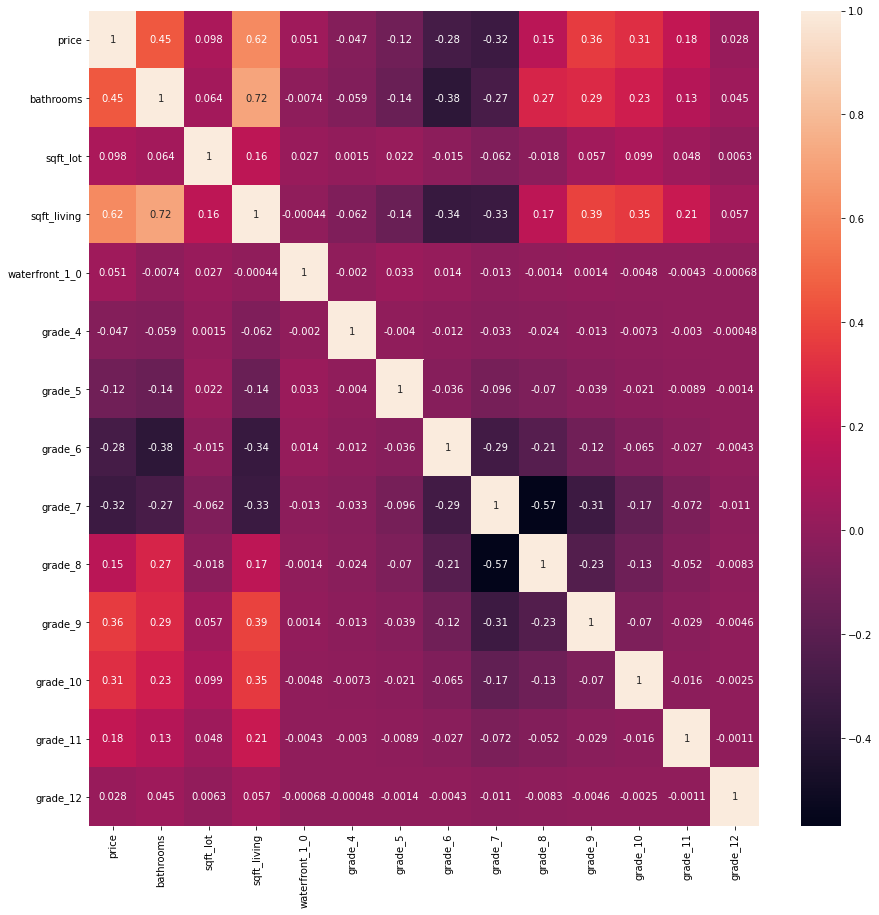

In [16]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model1.corr(),annot=True)

In [17]:
def correlation(dataframe):
    df= dataframe.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    df.set_index(['pairs'], inplace= True)
    
    df.drop(columns=['level_1', 'level_0'], inplace= True)
    
    df.columns= ['cc']
    
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc> .75) & (df.cc< 1)]

In [18]:
correlation(df_model1)

Empty DataFrame
Columns: [cc]
Index: []

In [19]:
train, test = train_test_split(df_model1)
print(len(train), len(test))

13581 4528


In [15]:
outcome = 'price'
x_cols = list(df_model1.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model1 = ols(formula=formula, data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     916.3
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:54:30   Log-Likelihood:            -1.8109e+05
No. Observations:               13581   AIC:                         3.622e+05
Df Residuals:                   13567   BIC:                         3.623e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.231e+05    1.5e+05      1.491      0.136   -7.02e+04    5.16e+05
bathrooms        -1.8e+04   2716.009     -6.629      0.000   -2.33e+04   -1.27e+04
sqft_lot           0.0026      0.034      0.076      0.940      -0.063       0.069
sqft_living      100.7844      2.797     36.028      0.000      95.301     106.268
waterfront_1_0  1.954e+05   2.57e+04      7.599      0.000    1.45e+05    2.46e+05
grade_4        -7.424e+04   1.54e+05     -0.483      0.629   -3.75e+05    2.27e+05
grade_5        -5.052e+04    1.5e+05     -0.337      0.736   -3.45e+05    2.44e+05
grade_6        -2.027e+04    1.5e+05     -0.135      0.892   -3.14e+05    2.73e+05
grade_7         4.176e+04    1.5e+05      0.279      0.780   -2.52e+05    3.35e+05
grade_8         1.242e+05    1.5e+05      0.830      0.406   -1.69e+05    4.18e+05
grade_9         2.222e+05    1.5e+05      1.484      0.138   -7.13e+04    5.16e+05
grade_10        2.951e+05    1.5e+05      1.969      0.049    1282.058    5.89e+05
grade_11        3.665e+05   1.51e+05      2.434      0.015    7.14e+04    6.62e+05
grade_12        3.144e+05   1.83e+05      1.714      0.087   -4.52e+04    6.74e+05
==============================================================================
Omnibus:                      680.915   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.535
Skew:                           0.557   Prob(JB):                    1.79e-173
Kurtosis:                       3.405   Cond. No.                     1.53e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# Model 
# Define you target and features
features = ['bathrooms','sqft_lot','sqft_living','waterfront','grade']
target = ['price']

X = df[features] # feature matrix
Y = df[target]   # target vector

# Instantiate the linear regression estimator and fit the data 

model1_a = LinearRegression() #Instantiate
model1_a.fit(X, Y) # fit the data 

model1_a_predict = model1_a.predict(X) # Create Y predictions and use r2_score()

print('R^2:', r2_score(Y,model1_a_predict))


R^2: 0.4631831623492073


In [42]:
def r_squared(features, target, df):
    X = df[features] # feature matrix
    Y = df[target]   # target vector

# Instantiate the linear regression estimator and fit the data 

    model1_a = LinearRegression() #Instantiate
    model1_a.fit(X, Y) # fit the data 

    model1_a_predict = model1_a.predict(X) # Create Y predictions and use r2_score()

    print('R^2:', r2_score(Y,model1_a_predict))
    

In [43]:
r_squared(features, target, df)

R^2: 0.4631831623492073


# Model 1 Interpetation:

Overall: The R^2 of the model is 0.474. R-squared is a statistical measure of fit that suggests how much variation of the target value is explained by the dependent variables. A low R^2 suggests that these feature need some transformations or new features that have a better relationship to price. 

Omnibus: 702.0
The Omnibus D'Angostino's Test, statistical test for skewness and kurtosis
Since this value is high this also suggests the variables in the model need to be transformed.

Durbin-Watson: 1.975
If the value is between 1-2 than this suggests the model passes the homoskedasity

# Checking for Multicollinearity

We examined our variables for Multicollinearity by looking if there are corralations between variables that are greater than .75, however we still have not accounted for all possible developments. In order to access if there is any multicollinearity in our model we will use the method variance inflation factor after every model and modification to the model. We are searching for values that are equal to or greater than 5.

In [51]:
def vif(train):
    X = train[x_cols]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return list(zip(x_cols, vif))

In [52]:
vif(train)

[('bathrooms', 2.435811991682123),
 ('sqft_lot_log', 1.237070440440785),
 ('sqft_living_log', 3.211791255826748),
 ('waterfront', 1.0038921973977049),
 ('grade_4', 1.026209779982581),
 ('grade_5', 1.1662514428013089),
 ('grade_6', 1.7501813336232264),
 ('grade_7', 1.704764634406625),
 ('grade_9', 1.3205044493951774),
 ('grade_10', 1.193414565134619),
 ('grade_11', 1.0480502640434977)]

In [53]:
residuals = model1.resid

In [54]:
# Will be creating a function to look at QQ-plots and residual distribution
def norm_dist_assumption(residual):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))
    
    sm.graphics.qqplot(residual, dist=stats.norm, line='45', fit=True, ax=ax1)
    ax1.grid()
    ax1.set_title('Q-Q plot of normalized residuals')
    
    #This will create help you look at the distribution of the residuals and the normalized residuals
    sns.distplot(residual, color='blue', kde=False, fit=norm, ax=ax2, vertical=True,)
    ax2.grid()
    ax2.set_xlabel("Count");
    ax2.set_ylabel("Residual");
    ax2.set_title('Histogram of normalized residuals')

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


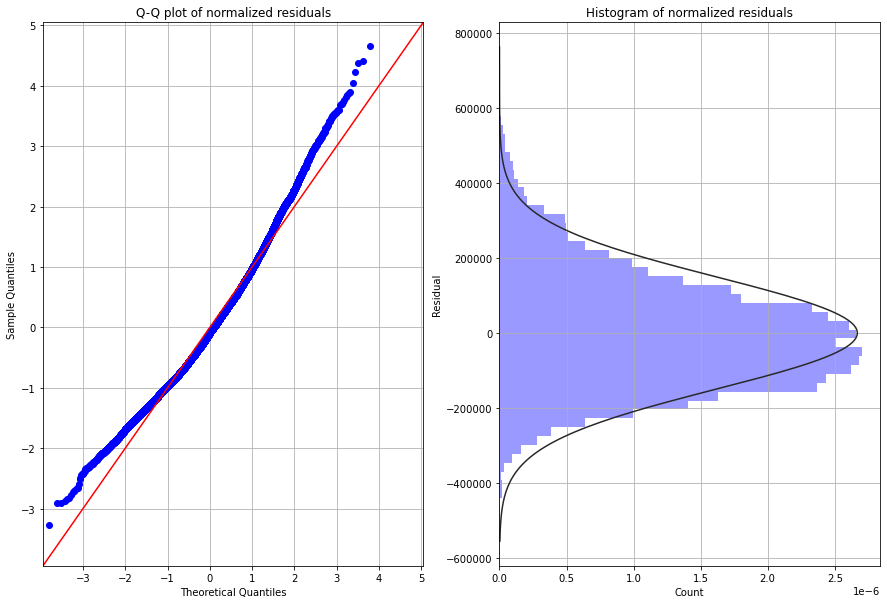

In [55]:
norm_dist_assumption(residuals)

In [56]:
# Will create a function to test for heteroskedasity
def Heteroskedasticity_test(model):
    plt.figure(figsize=(15,10))
    ax = sns.scatterplot(x = model.fittedvalues, y = model.resid)
    ax.grid()
    ax.axhline(y=0, color='r', linewidth=4) 
    ax.set_xlabel("Fitted Values");
    ax.set_ylabel("Residual");

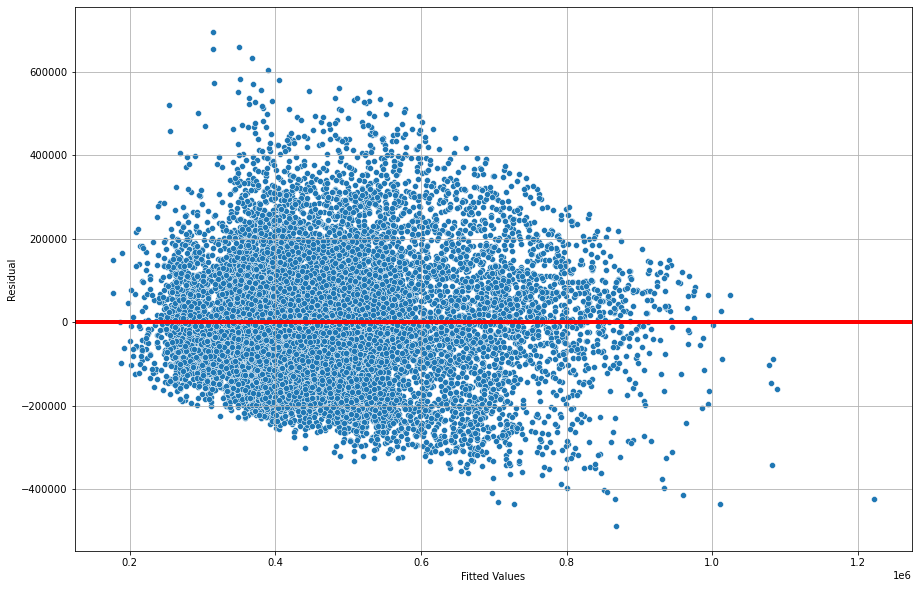

In [57]:
Heteroskedasticity_test(model1)

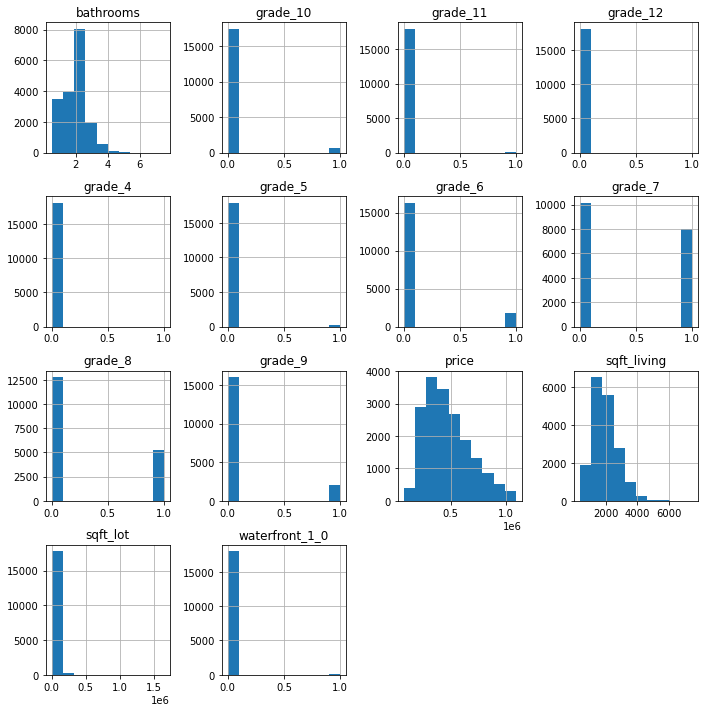

In [24]:
# Checking the distribution of the data to see if it is normal
df_model1.hist(figsize=(10,10))
plt.tight_layout();

As you can see that most of the continous variables are not normally distributed. 

# Model 2

On the first model there were a few features that struggled with being normally distributed. To fix this issue we need to transform features by using techniques like performing log transformation and quantile transformation. In this next model we will experiment with log transformation. 

In [30]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 42 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
School_dist_avg_log                 18109 non-null float64
ef_School_dist_avg_log              18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
viol_crime_log                      18103 non-null float64
prop_crime_log                      18103 non-null float64
totalcrime_percapita_log            18103 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_Sch

In [26]:
# We decide to log transform the continous vaiables followed by normalizing the values. For more details on our process please 
# refer to the notebook titled 'Data_Pred'
df_norm.head()

log_price  log_School_Elementary  log_School_K_12  ef_School_K_12_log  \
0   0.498255              -0.936137         0.238318            0.039586   
1  -1.981504              -1.852775        -1.046947           -1.353662   
2   0.760330               0.750625         0.469516            0.226359   
3   0.377205               0.302235        -0.215221           -1.288535   
4  -1.170555               0.263123        -1.718673           -0.799643   

   medical_dist_log  transport_dist_log  viol_crime_log  prop_crime_log  \
0         -0.367967           -1.142267        0.115536       -0.090661   
1          0.650214            0.677187       -0.234330        0.002646   
2          0.234602            0.563919       -0.571270       -0.567574   
3          2.392165            0.967465       -0.335851        0.050508   
4         -1.476924           -1.315559        0.537368        0.507307   

   totalcrime_percapita_log  School_Junior_High_Middle_log  ...  grade_rank_4  \
0                 -0.157430                      -0.768040  ...     -0.123944   
1                 -0.244318                       0.972042  ...     -0.123944   
2                 -0.877390                       0.288633  ...     -0.123944   
3                 -0.224585                       0.146330  ...     -0.123944   
4                  0.515483                       0.295690  ...     -0.123944   

   grade_rank_5  grade_rank_6  grade_rank_7  bins_walk_score_2  \
0     -0.327061      -0.31301     -0.376844          -0.552391   
1     -0.327061      -0.31301     -0.376844          -0.552391   
2     -0.327061      -0.31301     -0.376844          -0.552391   
3     -0.327061      -0.31301     -0.376844          -0.552391   
4     -0.327061      -0.31301      2.653471          -0.552391   

   bins_walk_score_3  bins_walk_score_4  bins_walk_score_5  \
0           2.214107          -0.506552          -0.114412   
1          -0.451624          -0.506552          -0.114412   
2          -0.451624           1.974020          -0.114412   
3          -0.451624          -0.506552          -0.114412   
4           2.214107          -0.506552          -0.114412   

   bins_total_crime_2  bins_total_crime_3  
0            -0.32861            -0.16606  
1            -0.32861            -0.16606  
2            -0.32861            -0.16606  
3            -0.32861            -0.16606  
4            -0.32861            -0.16606  

[5 rows x 42 columns]

In [31]:
target_value2 = ['log_price','bathrooms','sqft_lot_log','sqft_living_log','waterfront','grade_4','grade_5','grade_6','grade_7','grade_8','grade_9','grade_10','grade_11','grade_12',]

In [32]:
df_model2 = df_norm[target_value2]

In [33]:
df_model2

log_price  bathrooms  sqft_lot_log  sqft_living_log  waterfront  \
0       0.498255   0.283277     -0.085043         0.863210   -0.052617   
1      -1.981504  -1.481382      0.274759        -2.181299   -0.052617   
2       0.760330   1.342073     -0.498111         0.178763   -0.052617   
3       0.377205  -0.069655      0.037045        -0.210622   -0.052617   
4      -1.170555   0.283277     -0.152150        -0.158537   -0.052617   
...          ...        ...           ...              ...         ...   
18104   0.216185   0.636209     -2.005276        -0.839005   -0.052617   
18105  -0.411648   0.636209     -2.155397        -0.446868   -0.052617   
18106  -0.173025   0.636209     -0.330124         0.593791   -0.052617   
18107  -0.161160  -1.834314     -1.958037        -1.471071   -0.052617   
18108  -0.643292  -1.834314     -2.210983        -1.471071   -0.052617   

       grade_4   grade_5   grade_6   grade_7   grade_8   grade_9  grade_10  \
0     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
1     -0.03718 -0.108834  3.001667 -0.885293 -0.642204 -0.354619 -0.196156   
2     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
3     -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
4     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
...        ...       ...       ...       ...       ...       ...       ...   
18104 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18105 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18106 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18107 -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
18108 -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   

       grade_11  grade_12  
0     -0.081672 -0.012872  
1     -0.081672 -0.012872  
2     -0.081672 -0.012872  
3     -0.081672 -0.012872  
4     -0.081672 -0.012872  
...         ...       ...  
18104 -0.081672 -0.012872  
18105 -0.081672 -0.012872  
18106 -0.081672 -0.012872  
18107 -0.081672 -0.012872  
18108 -0.081672 -0.012872  

[18109 rows x 14 columns]

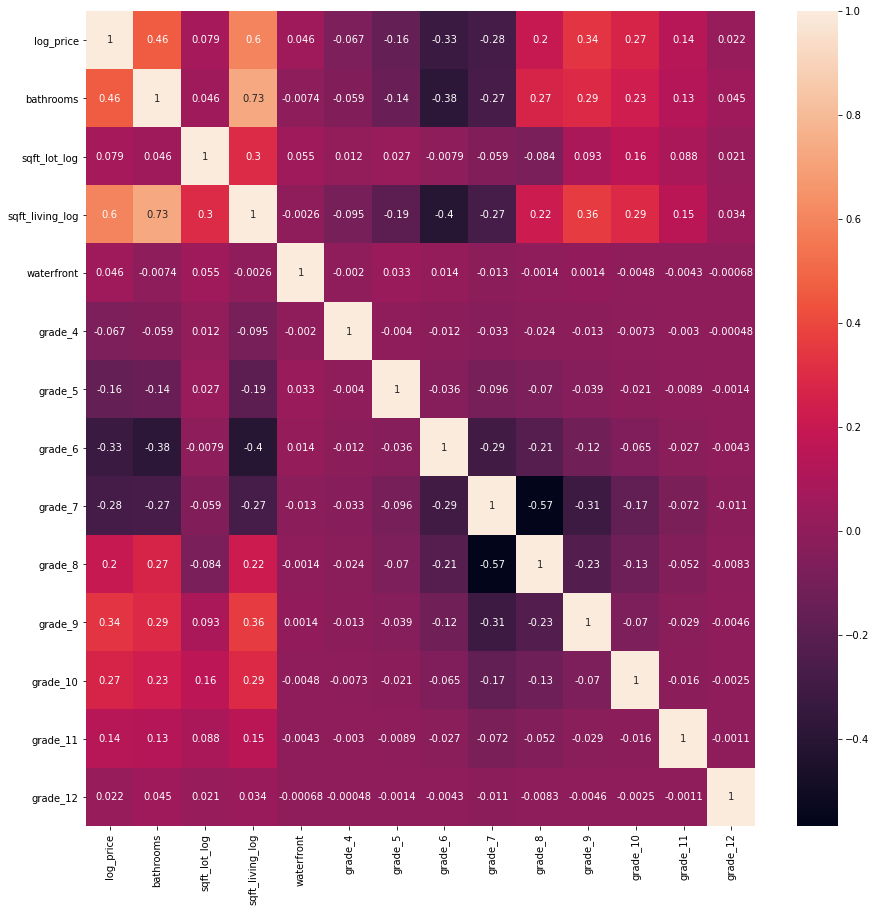

In [34]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model2.corr(),annot=True)

In [35]:
correlation(df_model2)

Empty DataFrame
Columns: [cc]
Index: []

In [36]:
train, test = train_test_split(df_model2)
print(len(train), len(test))

13581 4528


In [37]:
outcome = 'log_price'
x_cols = list(df_model2.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model2 = ols(formula=formula, data=train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     851.6
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:51:00   Log-Likelihood:                -15227.
No. Observations:               13581   AIC:                         3.048e+04
Df Residuals:                   13567   BIC:                         3.059e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0007      0.006      0.107      0.915      -0.012       0.013
bathrooms          -0.0739      0.010     -7.426      0.000      -0.093      -0.054
sqft_lot_log       -0.0904      0.007    -12.888      0.000      -0.104      -0.077
sqft_living_log     0.4077      0.011     35.674      0.000       0.385       0.430
waterfront          0.0523      0.007      7.685      0.000       0.039       0.066
grade_4            -0.0442      0.028     -1.558      0.119      -0.100       0.011
grade_5            -0.0967      0.080     -1.206      0.228      -0.254       0.060
grade_6            -0.1949      0.223     -0.874      0.382      -0.632       0.242
grade_7            -0.1483      0.369     -0.402      0.688      -0.872       0.575
grade_8             0.0474      0.338      0.140      0.889      -0.616       0.710
grade_9             0.1701      0.234      0.725      0.468      -0.289       0.630
grade_10            0.1571      0.141      1.116      0.264      -0.119       0.433
grade_11            0.0833      0.061      1.372      0.170      -0.036       0.202
grade_12            0.0097      0.012      0.826      0.409      -0.013       0.033
==============================================================================
Omnibus:                       49.709   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.850
Skew:                          -0.083   Prob(JB):                     4.96e-10
Kurtosis:                       2.781   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
features =['bathrooms','sqft_lot_log','sqft_living_log','waterfront','grade_4','grade_5','grade_6','grade_7','grade_8','grade_9','grade_10','grade_11','grade_12']
target =['log_price']
r_squared(features, target, df_norm)

R^2: 0.4510257892613325


# Model 2 Interpetation:

Overall: The R^2 actually decrease from 0.474 to 0.449. Although, the value has decrease you will notice that there are other aspect of this model that suggest it is more reliable.

Omnibus: The Ominbus has decrease substantially which suggest that the coef are more reliable. 

Durbin-Watson: However, the Durbin-Watson has suffered.

In [43]:
vif(train)

[('bathrooms', 2.4542317474143975),
 ('sqft_lot_log', 1.229235005981897),
 ('sqft_living_log', 3.2226220447326566),
 ('waterfront', 1.0043157877708926),
 ('grade_4', 18.97606007124498),
 ('grade_5', 169.9106466459039),
 ('grade_6', 1232.8989576743336),
 ('grade_7', 3349.626059766414),
 ('grade_8', 2805.8450951974996),
 ('grade_9', 1362.4471419955553),
 ('grade_10', 487.88233390855777),
 ('grade_11', 84.79951437735505),
 ('grade_12', 3.012710879854409)]

In [44]:
residuals = model2.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


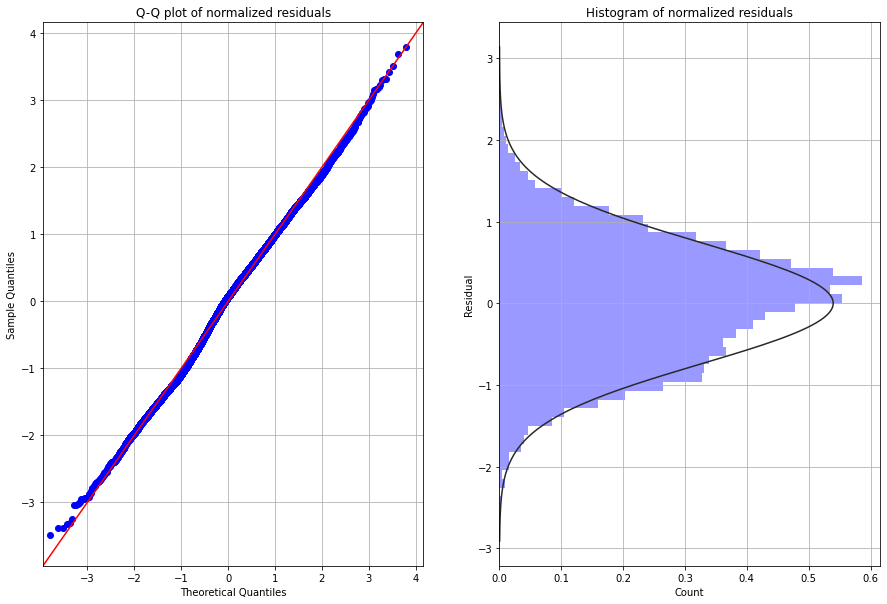

In [45]:
norm_dist_assumption(residuals)

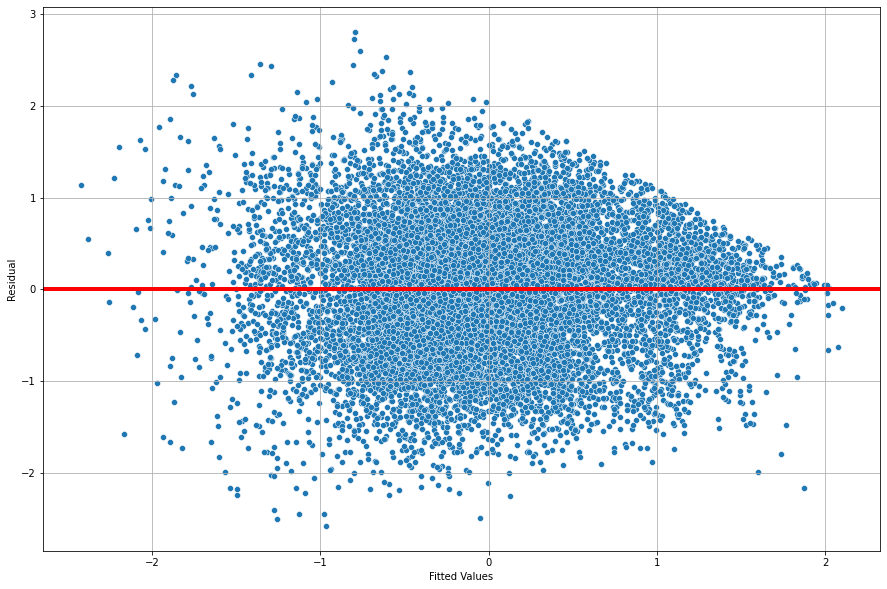

In [46]:
Heteroskedasticity_test(model2)

In [48]:
#Backward Elimination
# A technique that is used to iterate through the features an eliminate a feature so that all p-values are less than the confidence 
# level of alpha = 0.05
y = df_model2['log_price']
cols = x_cols
X = df_model2[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['bathrooms', 'sqft_lot_log', 'sqft_living_log', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [49]:
predictors_be_2 = '+'.join(selected_features_BE_norm)
formula_be_2 = outcome + '~' + predictors_be_2
model_be_2 = ols(formula=formula_be_2, data=train).fit()
model_be_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1006.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:06:25   Log-Likelihood:                -15228.
No. Observations:               13581   AIC:                         3.048e+04
Df Residuals:                   13569   BIC:                         3.057e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0007      0.006      0.105      0.917      -0.012       0.013
bathrooms          -0.0733      0.010     -7.376      0.000      -0.093      -0.054
sqft_lot_log       -0.0902      0.007    -12.874      0.000      -0.104      -0.076
sqft_living_log     0.4079      0.011     35.716      0.000       0.385       0.430
waterfront          0.0523      0.007      7.684      0.000       0.039       0.066
grade_4            -0.0480      0.007     -7.084      0.000      -0.061      -0.035
grade_5            -0.1078      0.007    -16.275      0.000      -0.121      -0.095
grade_6            -0.2259      0.008    -26.653      0.000      -0.242      -0.209
grade_7            -0.1999      0.008    -24.011      0.000      -0.216      -0.184
grade_9             0.1370      0.007     18.839      0.000       0.123       0.151
grade_10            0.1372      0.007     19.998      0.000       0.124       0.151
grade_11            0.0748      0.007     11.005      0.000       0.061       0.088
==============================================================================
Omnibus:                       49.965   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.030
Skew:                          -0.083   Prob(JB):                     4.53e-10
Kurtosis:                       2.781   Cond. No.                         3.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
vif(train[selected_features_BE_norm])

[('bathrooms', 2.435811991682123),
 ('sqft_lot_log', 1.237070440440785),
 ('sqft_living_log', 3.211791255826748),
 ('waterfront', 1.0038921973977049),
 ('grade_4', 1.026209779982581),
 ('grade_5', 1.1662514428013089),
 ('grade_6', 1.7501813336232264),
 ('grade_7', 1.704764634406625),
 ('grade_9', 1.3205044493951774),
 ('grade_10', 1.193414565134619),
 ('grade_11', 1.0480502640434977)]

## Model 2 after Backward Elimination interperation:



This techinque eliminated both variable grade_8 and grade_12. You can also see that this technique is useful in elimating any multicolinearity.

# Model 3
In this model we will be adding the average grade ranks per district. Looking at the relationship between price and grade_rank it was clear that there was a positive linear relationship. Homes that were located on the top grade ranks were found to have a higher value. For more details on the how we gathered this data and how we categorized it please refer to our notebook titled 'Understanding_the_Data&Compiling_Dataset'
Grade_ranks 1-7 are assosiated with letter grades A+ - C+. Data obtained from niche.com

In [59]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 42 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
School_dist_avg_log                 18109 non-null float64
ef_School_dist_avg_log              18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
viol_crime_log                      18103 non-null float64
prop_crime_log                      18103 non-null float64
totalcrime_percapita_log            18103 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_Sch

In [62]:
target3 =  ['log_price','bathrooms','sqft_lot_log','sqft_living_log','waterfront',
            'grade_4','grade_5','grade_6','grade_7','grade_8','grade_9','grade_10','grade_11','grade_12',
            'grade_rank_2','grade_rank_3', 'grade_rank_4','grade_rank_5','grade_rank_6','grade_rank_7']
df_model3 = df_norm[target3]

In [63]:
df_model3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 20 columns):
log_price          18109 non-null float64
bathrooms          18109 non-null float64
sqft_lot_log       18109 non-null float64
sqft_living_log    18109 non-null float64
waterfront         18109 non-null float64
grade_4            18109 non-null float64
grade_5            18109 non-null float64
grade_6            18109 non-null float64
grade_7            18109 non-null float64
grade_8            18109 non-null float64
grade_9            18109 non-null float64
grade_10           18109 non-null float64
grade_11           18109 non-null float64
grade_12           18109 non-null float64
grade_rank_2       18109 non-null float64
grade_rank_3       18109 non-null float64
grade_rank_4       18109 non-null float64
grade_rank_5       18109 non-null float64
grade_rank_6       18109 non-null float64
grade_rank_7       18109 non-null float64
dtypes: float64(20)
memory usage: 2.8 MB


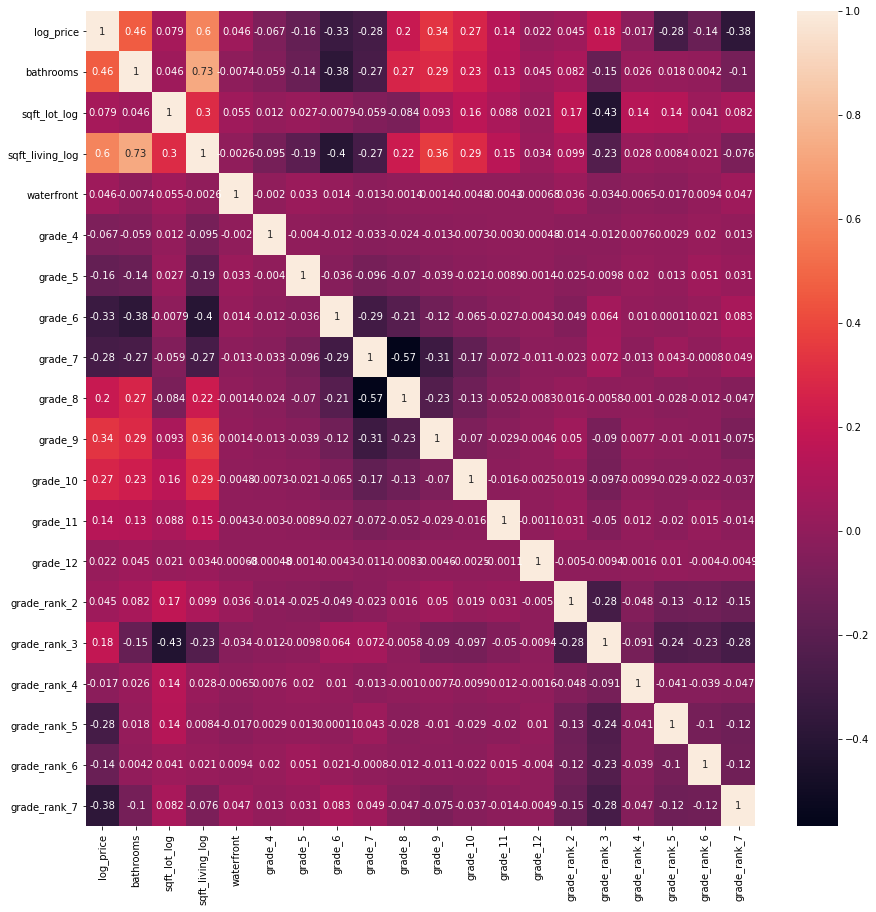

In [64]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model3.corr(),annot=True)

In [65]:
correlation(df_model3)

Empty DataFrame
Columns: [cc]
Index: []

In [66]:
train, test = train_test_split(df_model3)
print(len(train), len(test))

13581 4528


In [67]:
outcome = 'log_price'
x_cols = list(df_model3.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model3 = ols(formula=formula, data=train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1796.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:29:59   Log-Likelihood:                -10632.
No. Observations:               13581   AIC:                         2.130e+04
Df Residuals:                   13561   BIC:                         2.145e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0051      0.005      1.132      0.258      -0.004       0.014
bathrooms          -0.0339      0.007     -4.757      0.000      -0.048      -0.020
sqft_lot_log        0.0650      0.006     11.584      0.000       0.054       0.076
sqft_living_log     0.4046      0.008     49.702      0.000       0.389       0.421
waterfront          0.0680      0.005     14.815      0.000       0.059       0.077
grade_4            -0.0555      0.020     -2.740      0.006      -0.095      -0.016
grade_5            -0.1561      0.057     -2.730      0.006      -0.268      -0.044
grade_6            -0.4024      0.159     -2.530      0.011      -0.714      -0.091
grade_7            -0.5367      0.263     -2.039      0.041      -1.053      -0.021
grade_8            -0.3490      0.241     -1.447      0.148      -0.822       0.124
grade_9            -0.1377      0.167     -0.823      0.410      -0.466       0.190
grade_10           -0.0618      0.100     -0.616      0.538      -0.259       0.135
grade_11           -0.0011      0.043     -0.026      0.979      -0.086       0.084
grade_12           -0.0035      0.008     -0.417      0.677      -0.020       0.013
grade_rank_2       -0.1671      0.006    -30.169      0.000      -0.178      -0.156
grade_rank_3        0.0288      0.007      4.314      0.000       0.016       0.042
grade_rank_4       -0.0870      0.005    -18.556      0.000      -0.096      -0.078
grade_rank_5       -0.3768      0.005    -69.808      0.000      -0.387      -0.366
grade_rank_6       -0.2521      0.005    -47.421      0.000      -0.262      -0.242
grade_rank_7       -0.4176      0.006    -74.139      0.000      -0.429      -0.407
==============================================================================
Omnibus:                      248.743   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.194
Skew:                          -0.033   Prob(JB):                    1.34e-112
Kurtosis:                       3.952   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
features =['bathrooms','sqft_lot_log','sqft_living_log','waterfront',
           'grade_4','grade_5','grade_6','grade_7','grade_8','grade_9','grade_10','grade_11','grade_12',
           'grade_rank_2','grade_rank_3', 'grade_rank_4','grade_rank_5','grade_rank_6','grade_rank_7']
target =['log_price']
r_squared(features, target, df_norm)

R^2: 0.7154158452659953


In [70]:
vif(train)

[('bathrooms', 2.451711336984053),
 ('sqft_lot_log', 1.4965985397996906),
 ('sqft_living_log', 3.174421830495879),
 ('waterfront', 1.0072077248393152),
 ('grade_4', 17.989507744131423),
 ('grade_5', 152.42337059138185),
 ('grade_6', 1224.108687230154),
 ('grade_7', 3357.6317979353494),
 ('grade_8', 2812.5099628292774),
 ('grade_9', 1343.99313704172),
 ('grade_10', 479.0319771910301),
 ('grade_11', 92.8134180666651),
 ('grade_12', 3.0139510407188093),
 ('grade_rank_2', 1.4724654731442293),
 ('grade_rank_3', 2.1559361739288883),
 ('grade_rank_4', 1.090933357190254),
 ('grade_rank_5', 1.4036206587546787),
 ('grade_rank_6', 1.374512217679245),
 ('grade_rank_7', 1.5263822685569508)]

In [71]:
residuals = model3.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


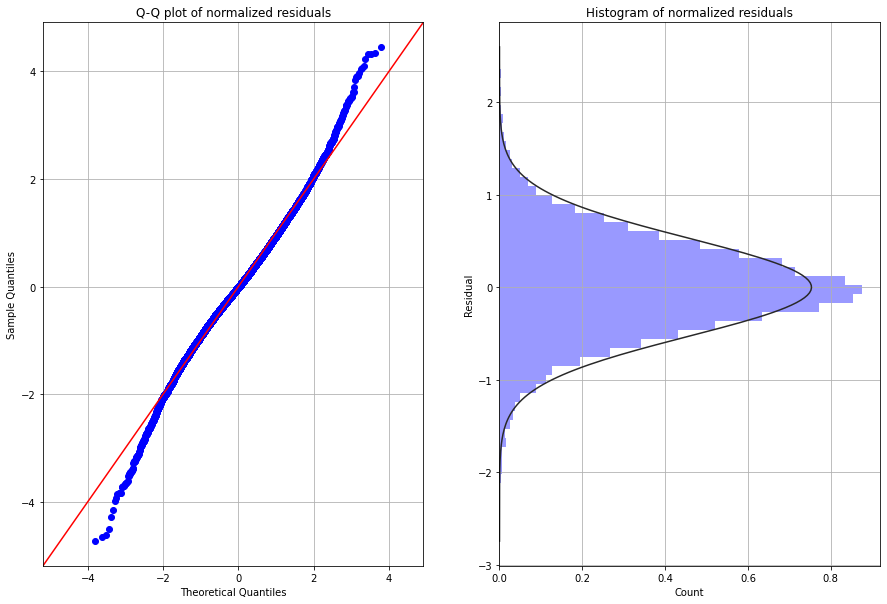

In [72]:
norm_dist_assumption(residuals)

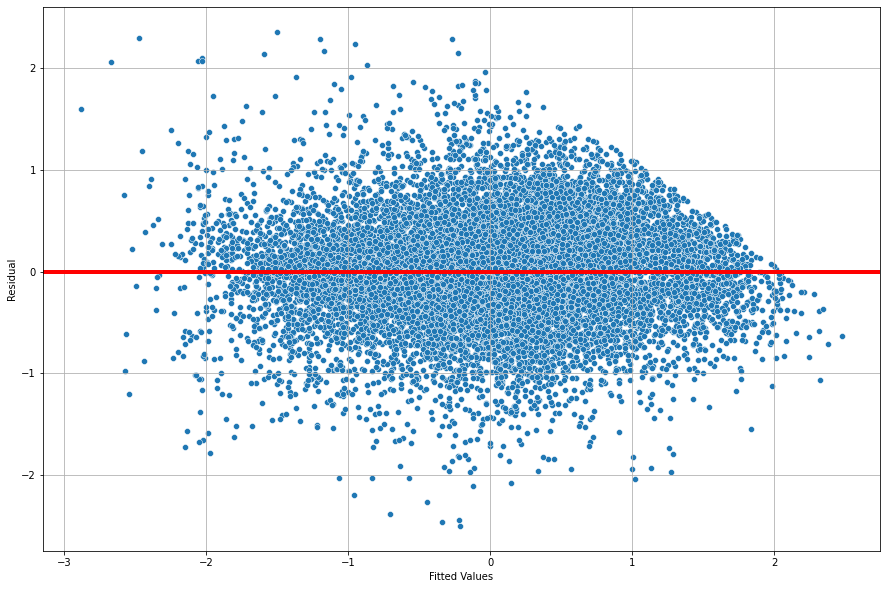

In [73]:
Heteroskedasticity_test(model3)

# Model 3 Interpetation:

Overall: Adding these school grade_rank feature has help out the R^2 from 0.49 all the way to 0.71. This is a strong indication how correlated these feature are to price. With the addition of these feature the model can better account for the variations of the target value.

However, residuals towards the end of the tails do not follow a normal distribution. 

Omnibus:249

Durbin-Watson:1.99

In [74]:
#Backward Elimination
y = df_model3['log_price']
cols = x_cols
X = df_model3[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['bathrooms', 'sqft_lot_log', 'sqft_living_log', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [75]:
predictors_be_3 = '+'.join(selected_features_BE_norm)
formula_be_3 = outcome + '~' + predictors_be_3
model_be_3 = ols(formula=formula_be_3, data=train).fit()
model_be_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     2007.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:38:25   Log-Likelihood:                -10632.
No. Observations:               13581   AIC:                         2.130e+04
Df Residuals:                   13563   BIC:                         2.143e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0052      0.005      1.134      0.257      -0.004       0.014
bathrooms          -0.0341      0.007     -4.787      0.000      -0.048      -0.020
sqft_lot_log        0.0649      0.006     11.579      0.000       0.054       0.076
sqft_living_log     0.4046      0.008     49.766      0.000       0.389       0.421
waterfront          0.0680      0.005     14.816      0.000       0.059       0.077
grade_4            -0.0548      0.005    -10.350      0.000      -0.065      -0.044
grade_5            -0.1541      0.008    -19.495      0.000      -0.170      -0.139
grade_6            -0.3967      0.018    -22.030      0.000      -0.432      -0.361
grade_7            -0.5273      0.028    -18.696      0.000      -0.583      -0.472
grade_8            -0.3403      0.025    -13.351      0.000      -0.390      -0.290
grade_9            -0.1316      0.018     -7.403      0.000      -0.166      -0.097
grade_10           -0.0582      0.011     -5.178      0.000      -0.080      -0.036
grade_rank_2       -0.1670      0.006    -30.165      0.000      -0.178      -0.156
grade_rank_3        0.0288      0.007      4.313      0.000       0.016       0.042
grade_rank_4       -0.0869      0.005    -18.553      0.000      -0.096      -0.078
grade_rank_5       -0.3768      0.005    -69.846      0.000      -0.387      -0.366
grade_rank_6       -0.2520      0.005    -47.421      0.000      -0.262      -0.242
grade_rank_7       -0.4176      0.006    -74.142      0.000      -0.429      -0.407
==============================================================================
Omnibus:                      248.844   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.391
Skew:                          -0.033   Prob(JB):                    1.21e-112
Kurtosis:                       3.952   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
vif(train[selected_features_BE_norm])

[('bathrooms', 2.4480037419330327),
 ('sqft_lot_log', 1.4963138139573233),
 ('sqft_living_log', 3.167011207730618),
 ('waterfront', 1.0072072290948249),
 ('grade_4', 1.2287943022506163),
 ('grade_5', 2.911482257417312),
 ('grade_6', 15.695831001663741),
 ('grade_7', 38.54885831618125),
 ('grade_8', 31.393796016732324),
 ('grade_9', 15.1952210879521),
 ('grade_10', 6.005498942756838),
 ('grade_rank_2', 1.4723022613819552),
 ('grade_rank_3', 2.1559268608281443),
 ('grade_rank_4', 1.0908836618444444),
 ('grade_rank_5', 1.4025185363806),
 ('grade_rank_6', 1.3744321192134543),
 ('grade_rank_7', 1.5263643964460503)]

# Model 4

In this model we will continue to explore the influence school features has on the price of a home. In order to do that we will be calculating the minimum distance to a school of interest. We gathered this data by using kingcounty.gov. For further explination on how we obtained the distance please refer to the notebook 'Understanding_the_Data&Compiling_Dataset'

In [77]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 42 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
School_dist_avg_log                 18109 non-null float64
ef_School_dist_avg_log              18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
viol_crime_log                      18103 non-null float64
prop_crime_log                      18103 non-null float64
totalcrime_percapita_log            18103 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_Sch

In [87]:
df_model4 = df_norm.drop(['police_station_dist_log','transport_dist_log','medical_dist_log',
                          'ef_School_K_12_log','ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log',
                          'ef_School_dist_avg_log', 'viol_crime_log', 'prop_crime_log','totalcrime_percapita_log',
                          'bins_walk_score_2_0', 'bins_walk_score_3_0', 'bins_walk_score_4_0', 'bins_walk_score_5_0',
                          'bins_total_crime_2_0', 'bins_total_crime_3_0',
                          'grade_8'], axis=1)
# I will be removing grade_8 as it always appears to have a high vif.

In [88]:
df_model4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
log_price                        18109 non-null float64
log_School_Elementary            18109 non-null float64
log_School_K_12                  18109 non-null float64
School_dist_avg_log              18109 non-null float64
School_Junior_High_Middle_log    18109 non-null float64
dist_School_High_log             18109 non-null float64
sqft_living_log                  18109 non-null float64
sqft_lot_log                     18109 non-null float64
bathrooms                        18109 non-null float64
waterfront                       18109 non-null float64
grade_4                          18109 non-null float64
grade_5                          18109 non-null float64
grade_6                          18109 non-null float64
grade_7                          18109 non-null float64
grade_9                          18109 non-null float64
grade_10                         18109 non-null flo

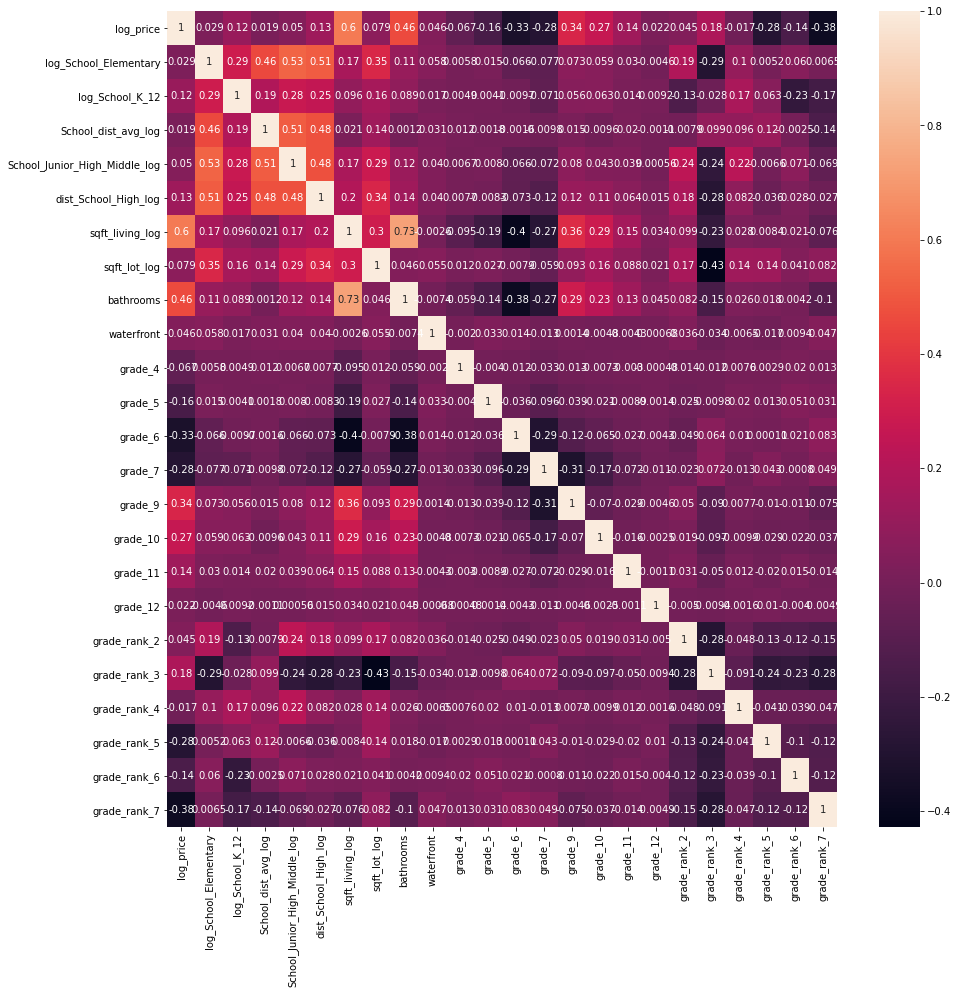

In [89]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model4.corr(),annot=True)

In [90]:
correlation(df_model4)

Empty DataFrame
Columns: [cc]
Index: []

In [91]:
train, test = train_test_split(df_model4)
print(len(train), len(test))

13581 4528


In [92]:
outcome = 'log_price'
x_cols = list(df_model4.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model4 = ols(formula=formula, data=train).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1527.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:50:05   Log-Likelihood:                -10586.
No. Observations:               13581   AIC:                         2.122e+04
Df Residuals:                   13557   BIC:                         2.140e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0003      0.005      0.057      0.955      -0.009       0.009
log_School_Elementary            -0.0203      0.006     -3.320      0.001      -0.032      -0.008
log_School_K_12                  -0.0979      0.006    -17.401      0.000      -0.109      -0.087
School_dist_avg_log               0.0002      0.006      0.038      0.970      -0.012       0.013
School_Junior_High_Middle_log     0.0036      0.006      0.564      0.573      -0.009       0.016
dist_School_High_log              0.0208      0.006      3.384      0.001       0.009       0.033
sqft_living_log                   0.3972      0.008     48.812      0.000       0.381       0.413
sqft_lot_log                      0.0810      0.006     13.872      0.000       0.070       0.092
bathrooms                        -0.0225      0.007     -3.133      0.002      -0.037      -0.008
waterfront                        0.0725      0.004     16.437      0.000       0.064       0.081
grade_4                          -0.0273      0.004     -6.117      0.000      -0.036      -0.019
grade_5                          -0.0796      0.005    -16.390      0.000      -0.089      -0.070
grade_6                          -0.1641      0.006    -26.934      0.000      -0.176      -0.152
grade_7                          -0.1529      0.006    -25.666      0.000      -0.165      -0.141
grade_9                           0.1024      0.005     19.553      0.000       0.092       0.113
grade_10                          0.0819      0.005     16.147      0.000       0.072       0.092
grade_11                          0.0629      0.005     13.090      0.000       0.053       0.072
grade_12                          0.0057      0.004      1.457      0.145      -0.002       0.013
grade_rank_2                     -0.2023      0.006    -33.160      0.000      -0.214      -0.190
grade_rank_3                     -0.0057      0.007     -0.781      0.435      -0.020       0.009
grade_rank_4                     -0.0837      0.005    -16.843      0.000      -0.093      -0.074
grade_rank_5                     -0.3946      0.006    -69.355      0.000      -0.406      -0.383
grade_rank_6                     -0.2932      0.006    -49.579      0.000      -0.305      -0.282
grade_rank_7                     -0.4586      0.006    -76.424      0.000      -0.470      -0.447
==============================================================================
Omnibus:                      325.960   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.747
Skew:                          -0.039   Prob(JB):                    2.35e-166
Kurtosis:                       4.158   Cond. No.                         4.54
==========================================

In [93]:
vif(train)

[('log_School_Elementary', 1.8083758327831396),
 ('log_School_K_12', 1.5379914999918618),
 ('School_dist_avg_log', 2.0032942073171047),
 ('School_Junior_High_Middle_log', 1.940993614609592),
 ('dist_School_High_log', 1.8330754979050714),
 ('sqft_living_log', 3.1955398012976075),
 ('sqft_lot_log', 1.6106889194367262),
 ('bathrooms', 2.483029079632708),
 ('waterfront', 1.011141974974351),
 ('grade_4', 1.0333234239481572),
 ('grade_5', 1.169744795818105),
 ('grade_6', 1.7969696197168674),
 ('grade_7', 1.7318575592948906),
 ('grade_9', 1.3208534369186666),
 ('grade_10', 1.1948038750829872),
 ('grade_11', 1.0503767478882757),
 ('grade_12', 1.0059004657659953),
 ('grade_rank_2', 1.8006221132111713),
 ('grade_rank_3', 2.6320033482093352),
 ('grade_rank_4', 1.1375613179457993),
 ('grade_rank_5', 1.590842668428189),
 ('grade_rank_6', 1.6806151973676289),
 ('grade_rank_7', 1.7732071138255716)]

In [94]:
residuals = model4.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


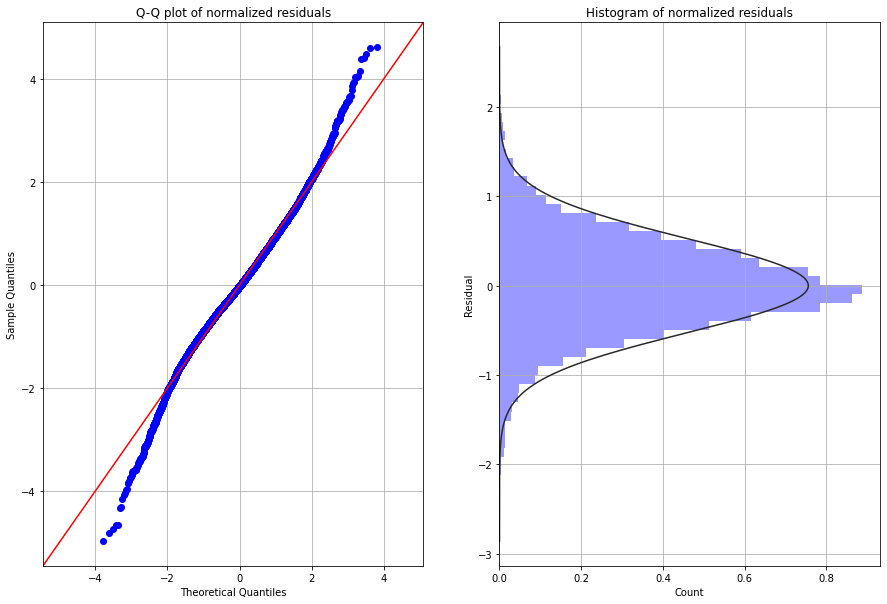

In [95]:
norm_dist_assumption(residuals)

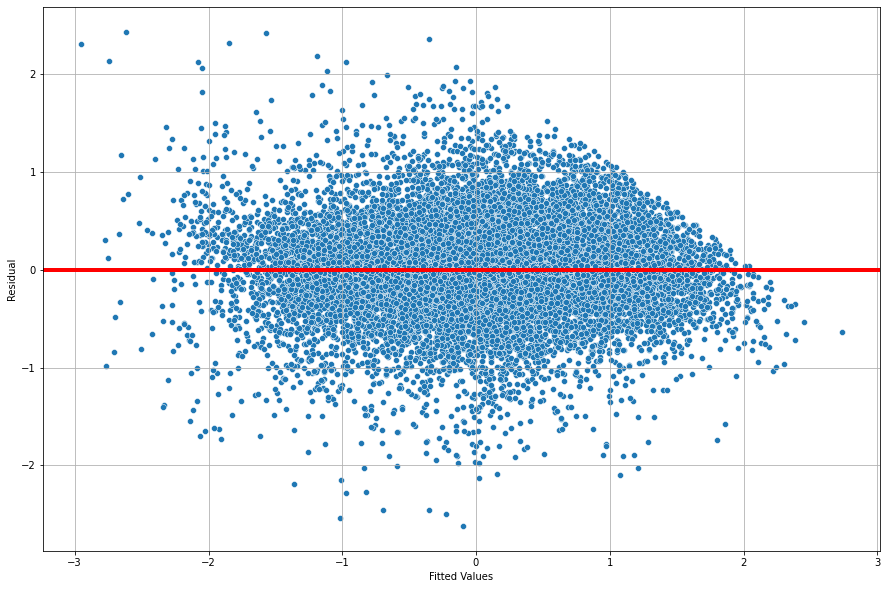

In [96]:
Heteroskedasticity_test(model4)

# Model 4 Interpetation:

Overall: Adding the distance to schools only increased the R^2 slightly. We thought the average distance between the 4 different type of schools would be more meaningful. Although there was a small linear correlation with price it did not translate that in to model. Instead these features had some of the lowest coef. We believe if we add some type of scale to these distance would help the coef.

Omnibus:325.960

Durbin-Watson:2.00

In [97]:
#Backward Elimination
y = df_model4['log_price']
cols = x_cols
X = df_model4[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['log_School_Elementary', 'log_School_K_12', 'dist_School_High_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_rank_2', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


In [98]:
predictors_be_4 = '+'.join(selected_features_BE_norm)
formula_be_4 = outcome + '~' + predictors_be_4
model_be_4 = ols(formula=formula_be_4, data=train).fit()
model_be_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1849.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:59:12   Log-Likelihood:                -10588.
No. Observations:               13581   AIC:                         2.122e+04
Df Residuals:                   13561   BIC:                         2.137e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0003      0.005      0.062      0.950      -0.009       0.009
log_School_Elementary    -0.0193      0.006     -3.422      0.001      -0.030      -0.008
log_School_K_12          -0.0965      0.005    -17.790      0.000      -0.107      -0.086
dist_School_High_log      0.0224      0.006      4.053      0.000       0.012       0.033
sqft_living_log           0.3975      0.008     48.895      0.000       0.382       0.413
sqft_lot_log              0.0822      0.006     14.360      0.000       0.071       0.093
bathrooms                -0.0217      0.007     -3.039      0.002      -0.036      -0.008
waterfront                0.0724      0.004     16.426      0.000       0.064       0.081
grade_4                  -0.0272      0.004     -6.108      0.000      -0.036      -0.018
grade_5                  -0.0796      0.005    -16.401      0.000      -0.089      -0.070
grade_6                  -0.1643      0.006    -27.054      0.000      -0.176      -0.152
grade_7                  -0.1531      0.006    -25.755      0.000      -0.165      -0.141
grade_9                   0.1024      0.005     19.572      0.000       0.092       0.113
grade_10                  0.0819      0.005     16.214      0.000       0.072       0.092
grade_11                  0.0628      0.005     13.080      0.000       0.053       0.072
grade_rank_2             -0.1994      0.005    -38.285      0.000      -0.210      -0.189
grade_rank_4             -0.0826      0.005    -17.176      0.000      -0.092      -0.073
grade_rank_5             -0.3923      0.005    -81.254      0.000      -0.402      -0.383
grade_rank_6             -0.2905      0.005    -56.911      0.000      -0.301      -0.281
grade_rank_7             -0.4559      0.005    -90.733      0.000      -0.466      -0.446
==============================================================================
Omnibus:                      329.214   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.152
Skew:                          -0.042   Prob(JB):                    1.29e-168
Kurtosis:                       4.166   Cond. No.                         3.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
vif(train[selected_features_BE_norm])

[('log_School_Elementary', 1.54428677804346),
 ('log_School_K_12', 1.4289163978001778),
 ('dist_School_High_log', 1.478432537418249),
 ('sqft_living_log', 3.190907105213477),
 ('sqft_lot_log', 1.5474489533749018),
 ('bathrooms', 2.4722668186622956),
 ('waterfront', 1.0105664954095683),
 ('grade_4', 1.0331186776004824),
 ('grade_5', 1.1686829673324237),
 ('grade_6', 1.7858766754702635),
 ('grade_7', 1.7254932901005429),
 ('grade_9', 1.316992765516301),
 ('grade_10', 1.1863195053284556),
 ('grade_11', 1.0498721231129864),
 ('grade_rank_2', 1.3121330842718473),
 ('grade_rank_4', 1.0642592349312736),
 ('grade_rank_5', 1.145588391685854),
 ('grade_rank_6', 1.252392056926366),
 ('grade_rank_7', 1.2434857343000443)]

By using the backwards elimiation technique it removed the School_dist_avg_log 

# Model 5

We will continue exploring school features in this model, however we plan on using an engineered feature comprised of both the distance to a school multipled to its respective district grade. This allows a scaling feature into this variable. By doing this we were able to demonstrate a more pronounced linear relationship to price.

In [102]:
df_model5 = df_norm.drop(['police_station_dist_log','transport_dist_log','medical_dist_log',
                          'log_School_K_12','School_Junior_High_Middle_log','dist_School_High_log','log_School_Elementary',
                          'School_dist_avg_log', 'viol_crime_log', 'prop_crime_log','totalcrime_percapita_log',
                          'bins_walk_score_2_0', 'bins_walk_score_3_0', 'bins_walk_score_4_0', 'bins_walk_score_5_0',
                          'bins_total_crime_2_0', 'bins_total_crime_3_0',
                          'grade_8'], axis=1)

In [103]:
df_model5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
log_price                           18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
ef_School_dist_avg_log              18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterfront                          18109 non-null float64
grade_4                             18109 non-null float64
grade_5                             18109 non-null float64
grade_6                             18109 non-null float64
grade_7                             18109 non-null float64
grade_9                             18109 non-null float64
grade_

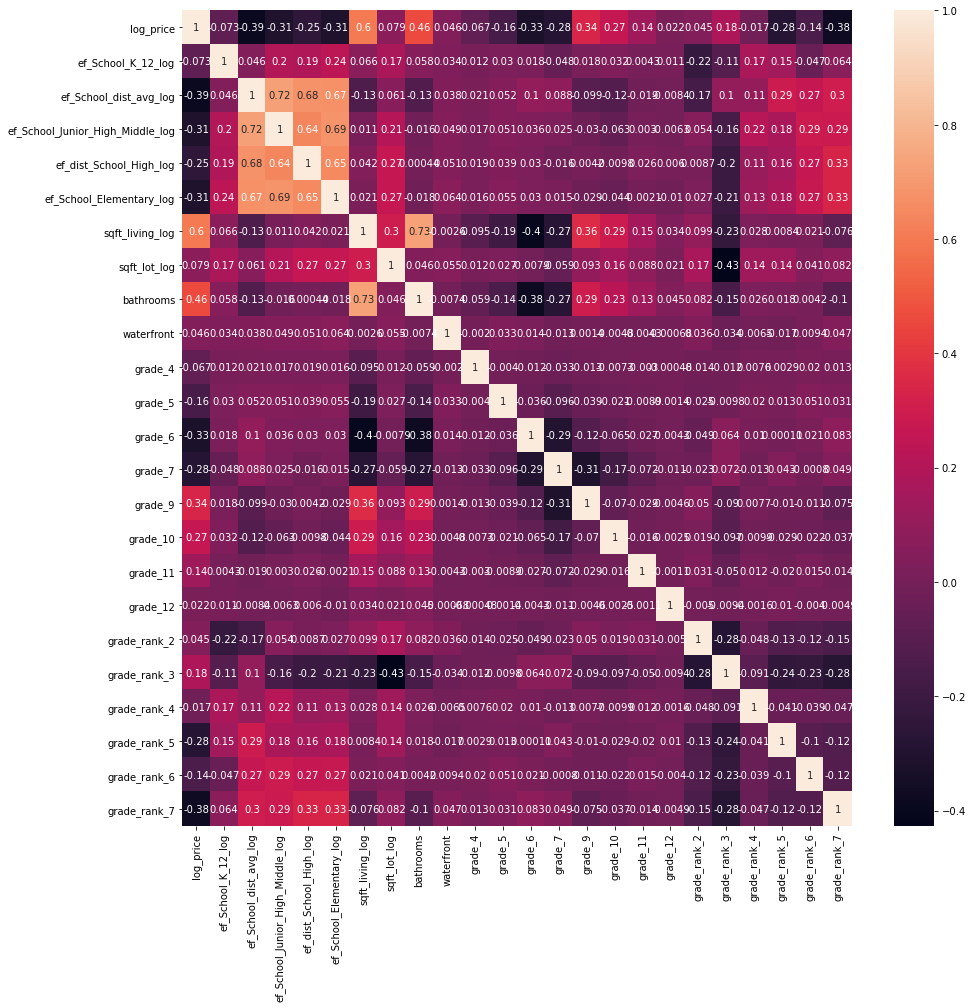

In [104]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model5.corr(),annot=True)

In [105]:
correlation(df_model5)

Empty DataFrame
Columns: [cc]
Index: []

In [106]:
train, test = train_test_split(df_model5)
print(len(train), len(test))

13581 4528


In [107]:
outcome = 'log_price'
x_cols = list(df_model5.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model5 = ols(formula=formula, data=train).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1522.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:12:45   Log-Likelihood:                -10612.
No. Observations:               13581   AIC:                         2.127e+04
Df Residuals:                   13557   BIC:                         2.145e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         9.569e-05      0.005      0.021      0.983      -0.009       0.009
ef_School_K_12_log                  -0.0816      0.005    -15.275      0.000      -0.092      -0.071
ef_School_dist_avg_log              -0.0293      0.011     -2.776      0.006      -0.050      -0.009
ef_School_Junior_High_Middle_log     0.0010      0.008      0.124      0.901      -0.015       0.017
ef_dist_School_High_log              0.0388      0.007      5.410      0.000       0.025       0.053
ef_School_Elementary_log            -0.0227      0.007     -3.071      0.002      -0.037      -0.008
sqft_living_log                      0.3921      0.008     48.228      0.000       0.376       0.408
sqft_lot_log                         0.0846      0.006     14.711      0.000       0.073       0.096
bathrooms                           -0.0189      0.007     -2.642      0.008      -0.033      -0.005
waterfront                           0.0707      0.004     15.798      0.000       0.062       0.079
grade_4                             -0.0266      0.004     -6.100      0.000      -0.035      -0.018
grade_5                             -0.0753      0.005    -15.298      0.000      -0.085      -0.066
grade_6                             -0.1682      0.006    -27.523      0.000      -0.180      -0.156
grade_7                             -0.1557      0.006    -26.069      0.000      -0.167      -0.144
grade_9                              0.1003      0.005     19.085      0.000       0.090       0.111
grade_10                             0.0852      0.005     17.273      0.000       0.076       0.095
grade_11                             0.0579      0.005     12.413      0.000       0.049       0.067
grade_12                             0.0105      0.005      2.184      0.029       0.001       0.020
grade_rank_2                        -0.1817      0.007    -27.781      0.000      -0.195      -0.169
grade_rank_3                         0.0306      0.009      3.427      0.001       0.013       0.048
grade_rank_4                        -0.0709      0.005    -13.449      0.000      -0.081      -0.061
grade_rank_5                        -0.3605      0.007    -48.957      0.000      -0.375      -0.346
grade_rank_6                        -0.2492      0.007    -33.740      0.000      -0.264      -0.235
grade_rank_7                        -0.4100      0.008    -51.345      0.000      -0.426      -0.394
==============================================================================
Omnibus:                      306.896   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.665
Skew:                           0.010   Prob(JB):                    9.64e-154
Kurtosis:                       4.116   

In [108]:
vif(train)

[('ef_School_K_12_log', 1.3928155979475358),
 ('ef_School_dist_avg_log', 5.429360028397375),
 ('ef_School_Junior_High_Middle_log', 3.082975961960179),
 ('ef_dist_School_High_log', 2.514236903492631),
 ('ef_School_Elementary_log', 2.659272168757157),
 ('sqft_living_log', 3.2101719710928163),
 ('sqft_lot_log', 1.6067049775629558),
 ('bathrooms', 2.4657114039717296),
 ('waterfront', 1.01070702491843),
 ('grade_4', 1.0368741602103808),
 ('grade_5', 1.1696825232944978),
 ('grade_6', 1.7948094891020665),
 ('grade_7', 1.73233513075153),
 ('grade_9', 1.3296720542655847),
 ('grade_10', 1.2137990371029428),
 ('grade_11', 1.0573014824046651),
 ('grade_12', 1.0023980398830747),
 ('grade_rank_2', 2.090483521668463),
 ('grade_rank_3', 3.8550893064230967),
 ('grade_rank_4', 1.3435967200123051),
 ('grade_rank_5', 2.6359232341179326),
 ('grade_rank_6', 2.630133422949216),
 ('grade_rank_7', 3.075731959165153)]

In [109]:
residuals = model5.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


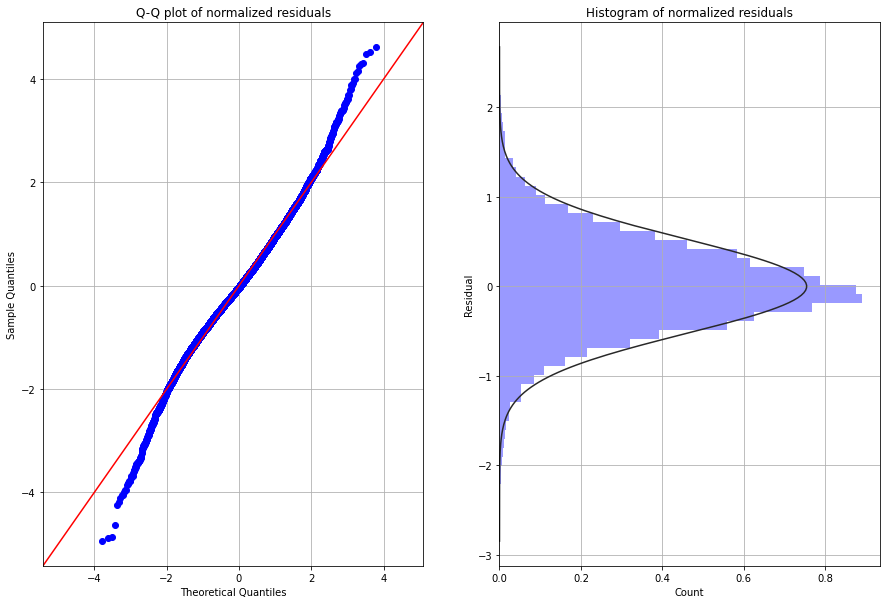

In [110]:
norm_dist_assumption(residuals)

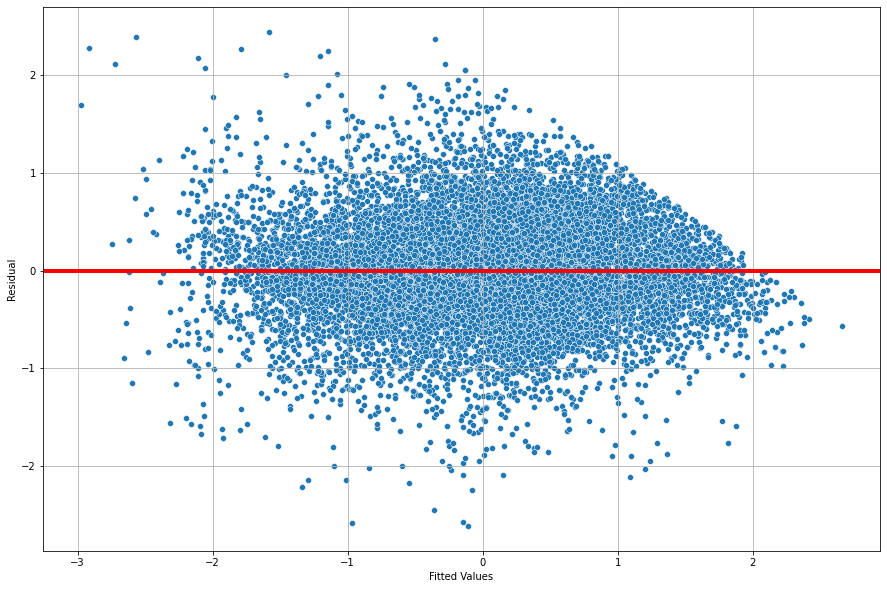

In [111]:
Heteroskedasticity_test(model5)

In [112]:
#Backward Elimination
y = df_model5['log_price']
cols = x_cols
X = df_model5[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12_log', 'ef_School_dist_avg_log', 'ef_dist_School_High_log', 'ef_School_Elementary_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [113]:
predictors_be_5 = '+'.join(selected_features_BE_norm)
formula_be_5 = outcome + '~' + predictors_be_5
model_be_5 = ols(formula=formula_be_5, data=train).fit()
model_be_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1666.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:15:01   Log-Likelihood:                -10615.
No. Observations:               13581   AIC:                         2.127e+04
Df Residuals:                   13559   BIC:                         2.144e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.435e-05      0.005      0.019      0.985      -0.009       0.009
ef_School_K_12_log          -0.0815      0.005    -15.624      0.000      -0.092      -0.071
ef_School_dist_avg_log      -0.0289      0.010     -2.975      0.003      -0.048      -0.010
ef_dist_School_High_log      0.0390      0.007      5.454      0.000       0.025       0.053
ef_School_Elementary_log    -0.0226      0.007     -3.101      0.002      -0.037      -0.008
sqft_living_log              0.3923      0.008     48.274      0.000       0.376       0.408
sqft_lot_log                 0.0848      0.006     14.748      0.000       0.073       0.096
bathrooms                   -0.0186      0.007     -2.599      0.009      -0.033      -0.005
waterfront                   0.0707      0.004     15.794      0.000       0.062       0.079
grade_4                     -0.0266      0.004     -6.092      0.000      -0.035      -0.018
grade_5                     -0.0753      0.005    -15.284      0.000      -0.085      -0.066
grade_6                     -0.1681      0.006    -27.510      0.000      -0.180      -0.156
grade_7                     -0.1557      0.006    -26.073      0.000      -0.167      -0.144
grade_9                      0.1000      0.005     19.042      0.000       0.090       0.110
grade_10                     0.0850      0.005     17.233      0.000       0.075       0.095
grade_11                     0.0578      0.005     12.390      0.000       0.049       0.067
grade_rank_2                -0.1816      0.006    -28.753      0.000      -0.194      -0.169
grade_rank_3                 0.0306      0.009      3.431      0.001       0.013       0.048
grade_rank_4                -0.0708      0.005    -13.713      0.000      -0.081      -0.061
grade_rank_5                -0.3604      0.007    -48.970      0.000      -0.375      -0.346
grade_rank_6                -0.2491      0.007    -34.170      0.000      -0.263      -0.235
grade_rank_7                -0.4099      0.008    -51.691      0.000      -0.425      -0.394
==============================================================================
Omnibus:                      306.258   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.444
Skew:                           0.011   Prob(JB):                    2.93e-153
Kurtosis:                       4.114   Cond. No.                         6.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
vif(train[selected_features_BE_norm])

[('ef_School_K_12_log', 1.3274610840647207),
 ('ef_School_dist_avg_log', 4.604865798214713),
 ('ef_dist_School_High_log', 2.5032996003176304),
 ('ef_School_Elementary_log', 2.5862094992585214),
 ('sqft_living_log', 3.207541835592456),
 ('sqft_lot_log', 1.6055880922711232),
 ('bathrooms', 2.464383721210653),
 ('waterfront', 1.0106843670655665),
 ('grade_4', 1.0368315495536071),
 ('grade_5', 1.1695252614217888),
 ('grade_6', 1.793872445780734),
 ('grade_7', 1.732226436220748),
 ('grade_9', 1.3290655970163743),
 ('grade_10', 1.2129988867568848),
 ('grade_11', 1.0569522760930172),
 ('grade_rank_2', 1.9489765970834139),
 ('grade_rank_3', 3.8547147593482185),
 ('grade_rank_4', 1.288969857770344),
 ('grade_rank_5', 2.631523757572668),
 ('grade_rank_6', 2.5620712212289822),
 ('grade_rank_7', 3.033142048249772)]

Will just move foward with ef_School_dist_avg_log

# Model 6
adding POI

In [121]:
df_model6= df_norm.drop(['ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log',
                          'log_School_K_12','School_Junior_High_Middle_log','dist_School_High_log','log_School_Elementary',
                          'School_dist_avg_log', 'viol_crime_log', 'prop_crime_log','totalcrime_percapita_log',
                          'bins_walk_score_2_0', 'bins_walk_score_3_0', 'bins_walk_score_4_0', 'bins_walk_score_5_0',
                          'bins_total_crime_2_0', 'bins_total_crime_3_0',
                          'grade_8'], axis=1)

In [122]:
df_model6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
log_price                  18109 non-null float64
ef_School_K_12_log         18109 non-null float64
ef_School_dist_avg_log     18109 non-null float64
medical_dist_log           18109 non-null float64
transport_dist_log         18109 non-null float64
police_station_dist_log    18109 non-null float64
sqft_living_log            18109 non-null float64
sqft_lot_log               18109 non-null float64
bathrooms                  18109 non-null float64
waterfront                 18109 non-null float64
grade_4                    18109 non-null float64
grade_5                    18109 non-null float64
grade_6                    18109 non-null float64
grade_7                    18109 non-null float64
grade_9                    18109 non-null float64
grade_10                   18109 non-null float64
grade_11                   18109 non-null float64
grade_12                   18109 non-null

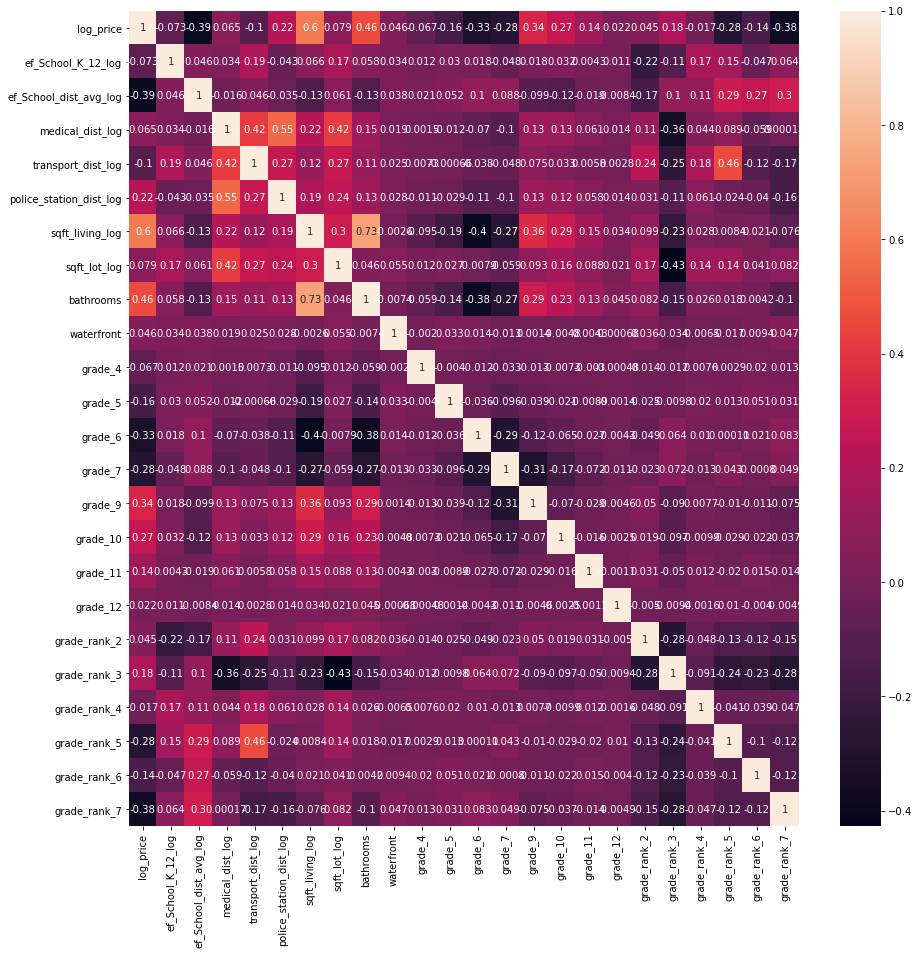

In [123]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model6.corr(),annot=True)

In [124]:
correlation(df_model6)

Empty DataFrame
Columns: [cc]
Index: []

In [125]:
train, test = train_test_split(df_model6)
print(len(train), len(test))

13581 4528


In [126]:
outcome = 'log_price'
x_cols = list(df_model6.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model6 = ols(formula=formula, data=train).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1558.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:30:34   Log-Likelihood:                -10413.
No. Observations:               13581   AIC:                         2.087e+04
Df Residuals:                   13557   BIC:                         2.105e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0012      0.004      0.266      0.791      -0.008       0.010
ef_School_K_12_log         -0.0714      0.005    -14.202      0.000      -0.081      -0.062
ef_School_dist_avg_log     -0.0080      0.008     -0.988      0.323      -0.024       0.008
medical_dist_log           -0.0768      0.006    -11.876      0.000      -0.089      -0.064
transport_dist_log         -0.0591      0.007     -9.060      0.000      -0.072      -0.046
police_station_dist_log     0.0319      0.006      5.498      0.000       0.021       0.043
sqft_living_log             0.3990      0.008     49.921      0.000       0.383       0.415
sqft_lot_log                0.1054      0.006     18.307      0.000       0.094       0.117
bathrooms                  -0.0171      0.007     -2.448      0.014      -0.031      -0.003
waterfront                  0.0677      0.004     15.306      0.000       0.059       0.076
grade_4                    -0.0209      0.005     -4.501      0.000      -0.030      -0.012
grade_5                    -0.0772      0.005    -15.990      0.000      -0.087      -0.068
grade_6                    -0.1747      0.006    -29.044      0.000      -0.187      -0.163
grade_7                    -0.1586      0.006    -27.170      0.000      -0.170      -0.147
grade_9                     0.1010      0.005     19.662      0.000       0.091       0.111
grade_10                    0.0852      0.005     17.272      0.000       0.075       0.095
grade_11                    0.0593      0.005     12.828      0.000       0.050       0.068
grade_12                    0.0105      0.005      2.207      0.027       0.001       0.020
grade_rank_2               -0.1731      0.007    -24.846      0.000      -0.187      -0.159
grade_rank_3               -0.0060      0.010     -0.607      0.544      -0.025       0.013
grade_rank_4               -0.0682      0.005    -12.627      0.000      -0.079      -0.058
grade_rank_5               -0.3453      0.009    -38.977      0.000      -0.363      -0.328
grade_rank_6               -0.2673      0.008    -34.347      0.000      -0.283      -0.252
grade_rank_7               -0.4217      0.008    -49.872      0.000      -0.438      -0.405
==============================================================================
Omnibus:                      337.290   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.221
Skew:                           0.004   Prob(JB):                    4.25e-177
Kurtosis:                       4.198   Cond. No.                         7.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
vif(train)

[('ef_School_K_12_log', 1.2700077708681328),
 ('ef_School_dist_avg_log', 3.2460918812731),
 ('medical_dist_log', 2.10346153249613),
 ('transport_dist_log', 2.129343460733727),
 ('police_station_dist_log', 1.6849650869613955),
 ('sqft_living_log', 3.173548370058587),
 ('sqft_lot_log', 1.6829246766550212),
 ('bathrooms', 2.4454065155251166),
 ('waterfront', 1.0159819930880658),
 ('grade_4', 1.0335816046993325),
 ('grade_5', 1.1571488058394266),
 ('grade_6', 1.7909656281864441),
 ('grade_7', 1.7021970960586157),
 ('grade_9', 1.3324534001246189),
 ('grade_10', 1.199937881877964),
 ('grade_11', 1.0561736760569465),
 ('grade_12', 1.0023875308532268),
 ('grade_rank_2', 2.4351093620347437),
 ('grade_rank_3', 4.8394474258214855),
 ('grade_rank_4', 1.4490495144154962),
 ('grade_rank_5', 3.8622195496281795),
 ('grade_rank_6', 3.0399809903143113),
 ('grade_rank_7', 3.565460927352063)]

In [128]:
residuals = model6.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


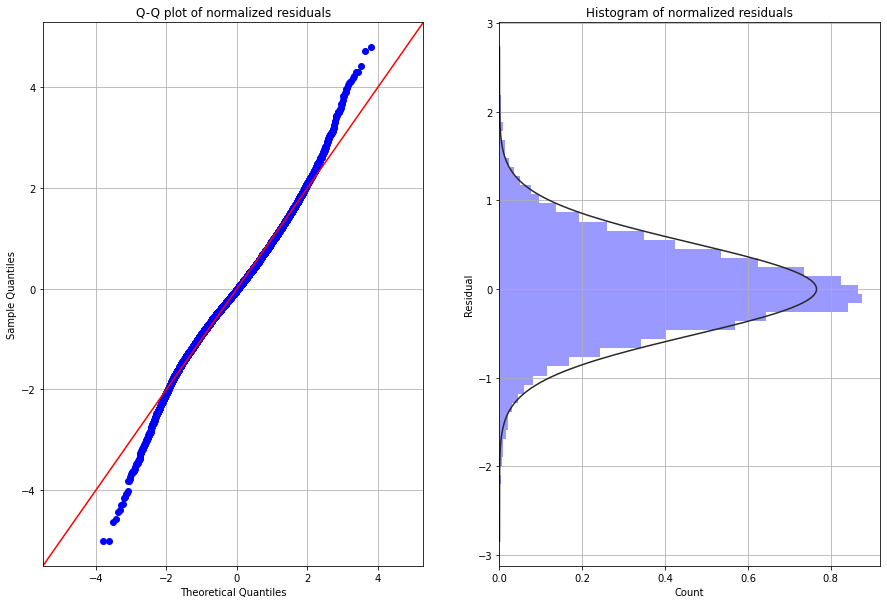

In [129]:
norm_dist_assumption(residuals)

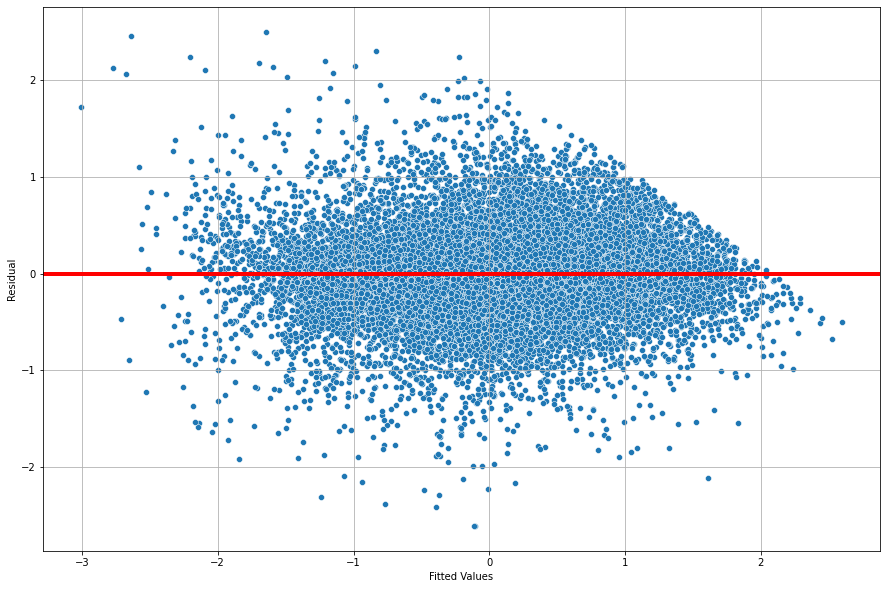

In [130]:
Heteroskedasticity_test(model6)

In [131]:
#Backward Elimination
y = df_model6['log_price']
cols = x_cols
X = df_model6[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['ef_School_K_12_log', 'medical_dist_log', 'transport_dist_log', 'police_station_dist_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_rank_2', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


In [132]:
predictors_be_6 = '+'.join(selected_features_BE_norm)
formula_be_6 = outcome + '~' + predictors_be_6
model_be_6 = ols(formula=formula_be_6, data=train).fit()
model_be_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:31:32   Log-Likelihood:                -10418.
No. Observations:               13581   AIC:                         2.088e+04
Df Residuals:                   13560   BIC:                         2.103e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0012      0.004      0.266      0.790      -0.008       0.010
ef_School_K_12_log         -0.0706      0.005    -14.304      0.000      -0.080      -0.061
medical_dist_log           -0.0751      0.006    -12.374      0.000      -0.087      -0.063
transport_dist_log         -0.0594      0.006     -9.420      0.000      -0.072      -0.047
police_station_dist_log     0.0313      0.006      5.499      0.000       0.020       0.042
sqft_living_log             0.3997      0.008     50.016      0.000       0.384       0.415
sqft_lot_log                0.1065      0.006     18.718      0.000       0.095       0.118
bathrooms                  -0.0164      0.007     -2.345      0.019      -0.030      -0.003
waterfront                  0.0674      0.004     15.251      0.000       0.059       0.076
grade_4                    -0.0208      0.005     -4.481      0.000      -0.030      -0.012
grade_5                    -0.0772      0.005    -16.000      0.000      -0.087      -0.068
grade_6                    -0.1753      0.006    -29.187      0.000      -0.187      -0.163
grade_7                    -0.1591      0.006    -27.279      0.000      -0.171      -0.148
grade_9                     0.1013      0.005     19.735      0.000       0.091       0.111
grade_10                    0.0856      0.005     17.408      0.000       0.076       0.095
grade_11                    0.0592      0.005     12.809      0.000       0.050       0.068
grade_rank_2               -0.1708      0.005    -32.136      0.000      -0.181      -0.160
grade_rank_4               -0.0689      0.005    -14.458      0.000      -0.078      -0.060
grade_rank_5               -0.3462      0.006    -61.362      0.000      -0.357      -0.335
grade_rank_6               -0.2680      0.005    -57.018      0.000      -0.277      -0.259
grade_rank_7               -0.4225      0.005    -86.297      0.000      -0.432      -0.413
==============================================================================
Omnibus:                      344.162   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.479
Skew:                          -0.002   Prob(JB):                    1.39e-182
Kurtosis:                       4.217   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
vif(train[selected_features_BE_norm])

[('ef_School_K_12_log', 1.4633802451094233),
 ('medical_dist_log', 2.0998658088198927),
 ('transport_dist_log', 2.064486607378678),
 ('ef_School_Junior_High_Middle_log', 2.720887902908797),
 ('ef_dist_School_High_log', 2.23533539714617),
 ('ef_School_Elementary_log', 2.513835663480775),
 ('police_station_dist_log', 1.608715268096872),
 ('sqft_living_log', 3.212975516608107),
 ('sqft_lot_log', 1.744301333719605),
 ('bathrooms', 2.4826923652721353),
 ('waterfront', 1.0144813716123848),
 ('grade_4', 1.336934824020116),
 ('grade_5', 3.415681287854342),
 ('grade_6', 17.509894581748302),
 ('grade_7', 44.36523221743668),
 ('grade_8', 36.291783930740806),
 ('grade_9', 17.35475379258544),
 ('grade_10', 6.889899252102841),
 ('grade_rank_2', 2.6749930775625366),
 ('grade_rank_3', 3.4317249472678544),
 ('grade_rank_4', 1.4420872996349774),
 ('grade_rank_5', 2.800808689968029),
 ('grade_rank_6', 2.7893198482524),
 ('grade_rank_7', 3.144867416524565)]

# Model 7

Adding Total crime data

In [165]:
df_model7= df_norm.drop(['ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log',
                          'log_School_K_12','School_Junior_High_Middle_log','dist_School_High_log','log_School_Elementary',
                          'School_dist_avg_log', 'viol_crime_log', 'prop_crime_log',
                          'bins_walk_score_2_0', 'bins_walk_score_3_0', 'bins_walk_score_4_0', 'bins_walk_score_5_0',
                          'bins_total_crime_2_0', 'bins_total_crime_3_0',
                          'grade_8'], axis=1)

In [166]:
df_model7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 25 columns):
log_price                   18109 non-null float64
ef_School_K_12_log          18109 non-null float64
ef_School_dist_avg_log      18109 non-null float64
medical_dist_log            18109 non-null float64
transport_dist_log          18109 non-null float64
totalcrime_percapita_log    18103 non-null float64
police_station_dist_log     18109 non-null float64
sqft_living_log             18109 non-null float64
sqft_lot_log                18109 non-null float64
bathrooms                   18109 non-null float64
waterfront                  18109 non-null float64
grade_4                     18109 non-null float64
grade_5                     18109 non-null float64
grade_6                     18109 non-null float64
grade_7                     18109 non-null float64
grade_9                     18109 non-null float64
grade_10                    18109 non-null float64
grade_11                

In [167]:
df_model7.dropna(inplace=True)

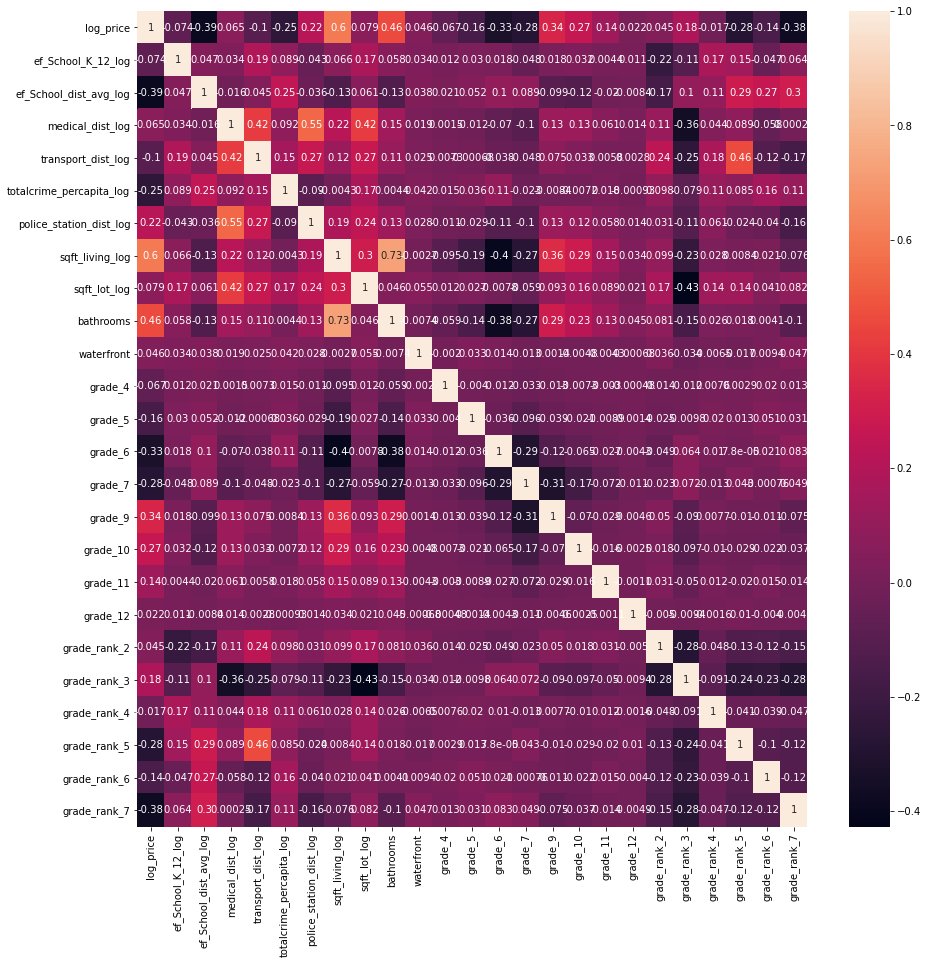

In [168]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model7.corr(),annot=True)

In [169]:
correlation(df_model7)

Empty DataFrame
Columns: [cc]
Index: []

In [170]:
train, test = train_test_split(df_model7)
print(len(train), len(test))

13577 4526


In [171]:
outcome = 'log_price'
x_cols = list(df_model7.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model7 = ols(formula=formula, data=train).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1602.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:56:54   Log-Likelihood:                -10159.
No. Observations:               13577   AIC:                         2.037e+04
Df Residuals:                   13552   BIC:                         2.056e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0031      0.004     -0.711      0.477      -0.012       0.005
ef_School_K_12_log          -0.0677      0.005    -13.665      0.000      -0.077      -0.058
ef_School_dist_avg_log      -0.0007      0.008     -0.092      0.927      -0.016       0.015
medical_dist_log            -0.0574      0.006     -9.055      0.000      -0.070      -0.045
transport_dist_log          -0.0491      0.006     -7.665      0.000      -0.062      -0.037
totalcrime_percapita_log    -0.1056      0.005    -21.688      0.000      -0.115      -0.096
police_station_dist_log      0.0180      0.006      3.164      0.002       0.007       0.029
sqft_living_log              0.3912      0.008     49.559      0.000       0.376       0.407
sqft_lot_log                 0.1088      0.006     18.829      0.000       0.097       0.120
bathrooms                   -0.0056      0.007     -0.803      0.422      -0.019       0.008
waterfront                   0.0737      0.004     16.973      0.000       0.065       0.082
grade_4                     -0.0250      0.005     -5.495      0.000      -0.034      -0.016
grade_5                     -0.0796      0.005    -16.624      0.000      -0.089      -0.070
grade_6                     -0.1697      0.006    -28.803      0.000      -0.181      -0.158
grade_7                     -0.1595      0.006    -27.627      0.000      -0.171      -0.148
grade_9                      0.1070      0.005     21.079      0.000       0.097       0.117
grade_10                     0.0884      0.005     18.282      0.000       0.079       0.098
grade_11                     0.0639      0.005     14.166      0.000       0.055       0.073
grade_12                     0.0014      0.005      0.302      0.762      -0.008       0.011
grade_rank_2                -0.1471      0.007    -20.900      0.000      -0.161      -0.133
grade_rank_3                 0.0310      0.010      3.139      0.002       0.012       0.050
grade_rank_4                -0.0592      0.005    -10.894      0.000      -0.070      -0.049
grade_rank_5                -0.3293      0.009    -37.256      0.000      -0.347      -0.312
grade_rank_6                -0.2370      0.008    -30.201      0.000      -0.252      -0.222
grade_rank_7                -0.3965      0.009    -46.578      0.000      -0.413      -0.380
==============================================================================
Omnibus:                      338.757   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.336
Skew:                          -0.015   Prob(JB):                    5.43e-178
Kurtosis:                       4.201   Cond. No.                         7.54
==============================================================================

Warn

In [172]:
residuals = model7.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


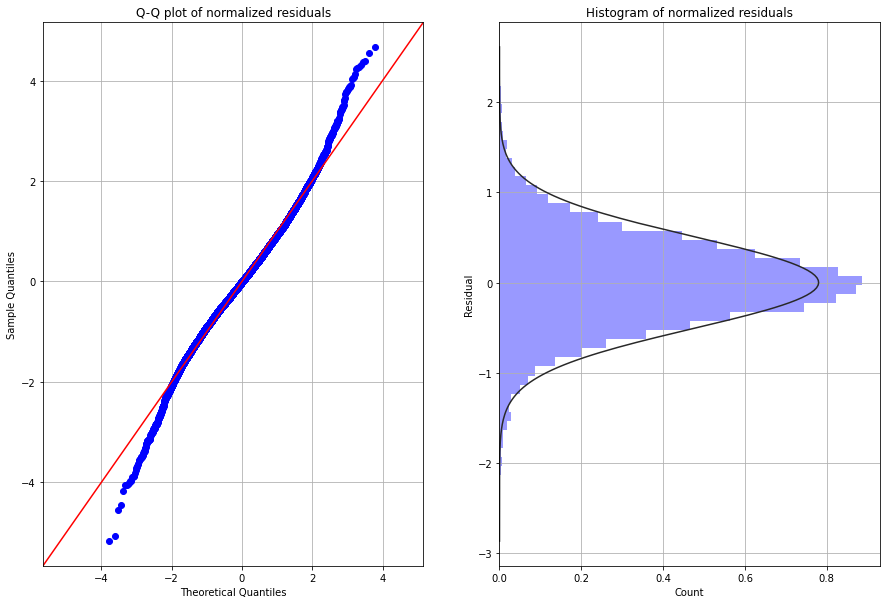

In [173]:
norm_dist_assumption(residuals)

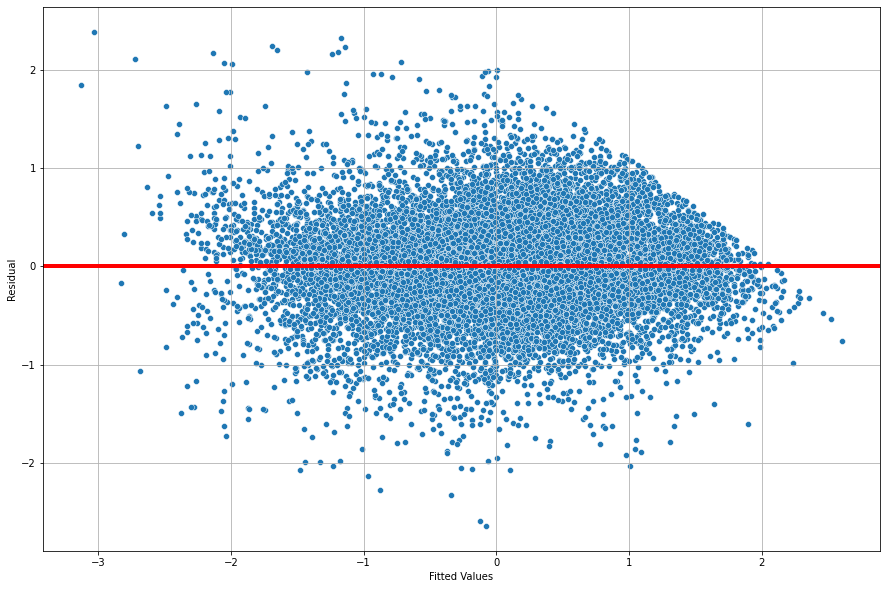

In [174]:
Heteroskedasticity_test(model7)

In [175]:
#Backward Elimination
y = df_model7['log_price']
cols = x_cols
X = df_model7[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12_log', 'medical_dist_log', 'transport_dist_log', 'totalcrime_percapita_log', 'police_station_dist_log', 'sqft_living_log', 'sqft_lot_log', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [176]:
predictors_be_7 = '+'.join(selected_features_BE_norm)
formula_be_7 = outcome + '~' + predictors_be_7
model_be_7 = ols(formula=formula_be_7, data=train).fit()
model_be_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1831.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:59:25   Log-Likelihood:                -10159.
No. Observations:               13577   AIC:                         2.036e+04
Df Residuals:                   13555   BIC:                         2.053e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0031      0.004     -0.712      0.476      -0.012       0.005
ef_School_K_12_log          -0.0679      0.005    -13.828      0.000      -0.078      -0.058
medical_dist_log            -0.0577      0.006     -9.350      0.000      -0.070      -0.046
transport_dist_log          -0.0491      0.006     -7.853      0.000      -0.061      -0.037
totalcrime_percapita_log    -0.1059      0.005    -21.786      0.000      -0.115      -0.096
police_station_dist_log      0.0179      0.006      3.210      0.001       0.007       0.029
sqft_living_log              0.3876      0.006     59.665      0.000       0.375       0.400
sqft_lot_log                 0.1100      0.006     19.860      0.000       0.099       0.121
waterfront                   0.0736      0.004     16.972      0.000       0.065       0.082
grade_4                     -0.0250      0.005     -5.489      0.000      -0.034      -0.016
grade_5                     -0.0794      0.005    -16.605      0.000      -0.089      -0.070
grade_6                     -0.1688      0.006    -29.183      0.000      -0.180      -0.157
grade_7                     -0.1587      0.006    -27.912      0.000      -0.170      -0.148
grade_9                      0.1069      0.005     21.076      0.000       0.097       0.117
grade_10                     0.0883      0.005     18.273      0.000       0.079       0.098
grade_11                     0.0637      0.005     14.142      0.000       0.055       0.073
grade_rank_2                -0.1475      0.006    -23.812      0.000      -0.160      -0.135
grade_rank_3                 0.0306      0.007      4.383      0.000       0.017       0.044
grade_rank_4                -0.0596      0.005    -12.219      0.000      -0.069      -0.050
grade_rank_5                -0.3300      0.006    -52.856      0.000      -0.342      -0.318
grade_rank_6                -0.2375      0.006    -42.886      0.000      -0.248      -0.227
grade_rank_7                -0.3970      0.006    -68.104      0.000      -0.408      -0.386
==============================================================================
Omnibus:                      338.659   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.182
Skew:                          -0.014   Prob(JB):                    5.86e-178
Kurtosis:                       4.201   Cond. No.                         4.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model 8
Adding bins

In [151]:
df_model8= df_norm.drop(['ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log',
                          'log_School_K_12','School_Junior_High_Middle_log','dist_School_High_log','log_School_Elementary',
                          'School_dist_avg_log', 'viol_crime_log', 'prop_crime_log',
                          'grade_8'], axis=1)

In [155]:
df_model8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 31 columns):
log_price                   18109 non-null float64
ef_School_K_12_log          18109 non-null float64
ef_School_dist_avg_log      18109 non-null float64
medical_dist_log            18109 non-null float64
transport_dist_log          18109 non-null float64
totalcrime_percapita_log    18103 non-null float64
police_station_dist_log     18109 non-null float64
sqft_living_log             18109 non-null float64
sqft_lot_log                18109 non-null float64
bathrooms                   18109 non-null float64
waterfront                  18109 non-null float64
grade_4                     18109 non-null float64
grade_5                     18109 non-null float64
grade_6                     18109 non-null float64
grade_7                     18109 non-null float64
grade_9                     18109 non-null float64
grade_10                    18109 non-null float64
grade_11                

In [156]:
df_model8.dropna(inplace=True)

In [158]:
correlation(df_model8)

Empty DataFrame
Columns: [cc]
Index: []

In [159]:
train, test = train_test_split(df_model8)
print(len(train), len(test))

13577 4526


In [160]:
outcome = 'log_price'
x_cols = list(df_model8.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model8 = ols(formula=formula, data=train).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1389.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:50:45   Log-Likelihood:                -9775.0
No. Observations:               13577   AIC:                         1.961e+04
Df Residuals:                   13546   BIC:                         1.985e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0023      0.004      0.533      0.594      -0.006       0.011
ef_School_K_12_log          -0.0647      0.005    -13.012      0.000      -0.074      -0.055
ef_School_dist_avg_log   -8.262e-05      0.008     -0.010      0.992      -0.016       0.016
medical_dist_log            -0.0732      0.006    -11.412      0.000      -0.086      -0.061
transport_dist_log           0.0241      0.007      3.477      0.001       0.010       0.038
totalcrime_percapita_log    -0.0689      0.006    -11.582      0.000      -0.081      -0.057
police_station_dist_log      0.0177      0.006      3.153      0.002       0.007       0.029
sqft_living_log              0.3912      0.008     50.859      0.000       0.376       0.406
sqft_lot_log                 0.1419      0.006     25.289      0.000       0.131       0.153
bathrooms                    0.0061      0.007      0.895      0.371      -0.007       0.019
waterfront                   0.0746      0.004     17.213      0.000       0.066       0.083
grade_4                     -0.0289      0.004     -6.541      0.000      -0.038      -0.020
grade_5                     -0.0706      0.005    -15.275      0.000      -0.080      -0.062
grade_6                     -0.1500      0.006    -25.916      0.000      -0.161      -0.139
grade_7                     -0.1488      0.006    -26.579      0.000      -0.160      -0.138
grade_9                      0.1075      0.005     21.843      0.000       0.098       0.117
grade_10                     0.0860      0.005     18.410      0.000       0.077       0.095
grade_11                     0.0614      0.004     13.830      0.000       0.053       0.070
grade_12                     0.0009      0.005      0.202      0.840      -0.008       0.010
grade_rank_2                -0.1995      0.008    -26.576      0.000      -0.214      -0.185
grade_rank_3                -0.0537      0.011     -5.091      0.000      -0.074      -0.033
grade_rank_4                -0.0798      0.006    -14.454      0.000      -0.091      -0.069
grade_rank_5                -0.3858      0.009    -40.957      0.000      -0.404      -0.367
grade_rank_6                -0.2388      0.008    -30.924      0.000      -0.254      -0.224
grade_rank_7                -0.3968      0.008    -47.691      0.000      -0.413      -0.381
bins_walk_score_2_0         -0.0093      0.006     -1.592      0.111      -0.021       0.002
bins_walk_score_3_0          0.0469      0.006      8.319      0.000       0.036       0.058
bins_walk_score_4_0          0.1555      0.007     23.001      0.000       0.142       0.169
bins_walk_score_5_0          0.0595      0.004     13.243      0.000       0.051       0.068
bins_total_crime_2_0        -0.0343      0.006     -6.164      0.000      -0.045      -0.023
bins_total_cri

In [161]:
vif(train)

[('ef_School_K_12_log', 1.3632260982757447),
 ('ef_School_dist_avg_log', 3.6179471302655157),
 ('medical_dist_log', 2.2464444150042953),
 ('transport_dist_log', 2.640649290960999),
 ('totalcrime_percapita_log', 1.9176026944224058),
 ('police_station_dist_log', 1.7447456726315334),
 ('sqft_living_log', 3.2100144809556705),
 ('sqft_lot_log', 1.7520460617678615),
 ('bathrooms', 2.503697561686703),
 ('waterfront', 1.0173170214979848),
 ('grade_4', 1.030519631979848),
 ('grade_5', 1.1574437940167825),
 ('grade_6', 1.8079400597100264),
 ('grade_7', 1.7169918206684875),
 ('grade_9', 1.3299270459871813),
 ('grade_10', 1.2184571057992797),
 ('grade_11', 1.0584328759864543),
 ('grade_12', 1.0046188938134821),
 ('grade_rank_2', 3.13054967618554),
 ('grade_rank_3', 6.096663150256852),
 ('grade_rank_4', 1.674031232814468),
 ('grade_rank_5', 4.919220085783507),
 ('grade_rank_6', 3.187306892592268),
 ('grade_rank_7', 3.767029388237055),
 ('bins_walk_score_2_0', 1.8787179453135694),
 ('bins_walk_score

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


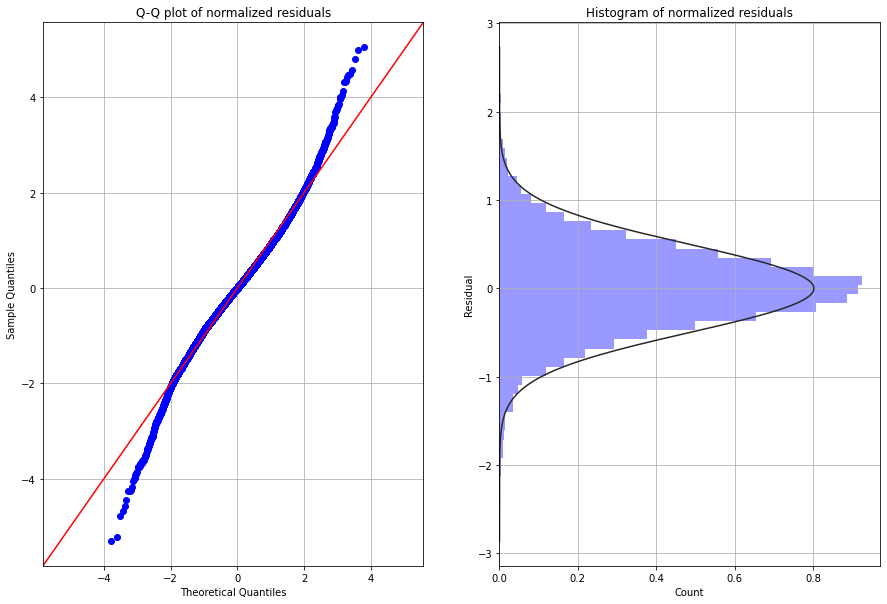

In [163]:
residuals = model8.resid
norm_dist_assumption(residuals)

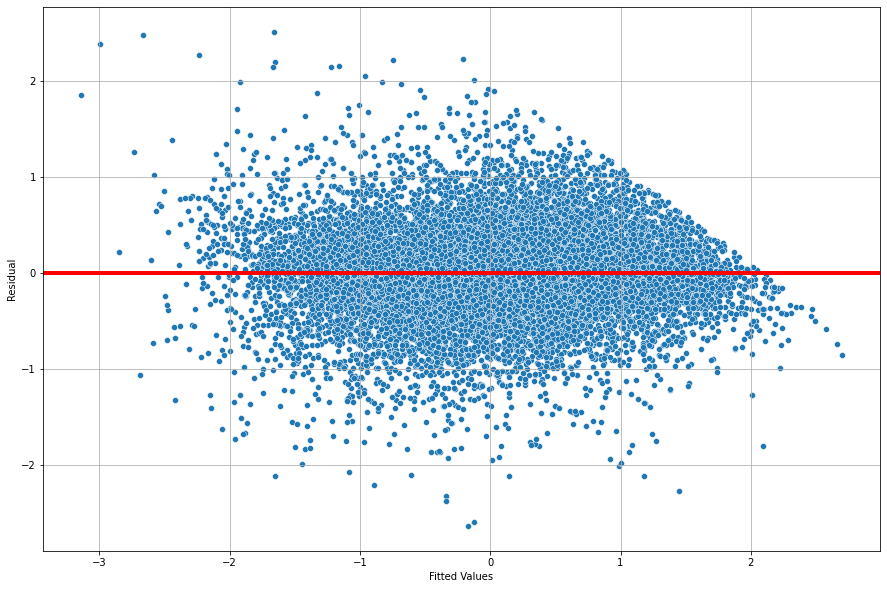

In [164]:
Heteroskedasticity_test(model8)

In [177]:
#Backward Elimination
y = df_model8['log_price']
cols = x_cols
X = df_model8[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12_log', 'medical_dist_log', 'transport_dist_log', 'totalcrime_percapita_log', 'police_station_dist_log', 'sqft_living_log', 'sqft_lot_log', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


In [178]:
predictors_be_8 = '+'.join(selected_features_BE_norm)
formula_be_8 = outcome + '~' + predictors_be_8
model_be_8 = ols(formula=formula_be_8, data=train).fit()
model_be_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1831.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:02:31   Log-Likelihood:                -10159.
No. Observations:               13577   AIC:                         2.036e+04
Df Residuals:                   13555   BIC:                         2.053e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0031      0.004     -0.712      0.476      -0.012       0.005
ef_School_K_12_log          -0.0679      0.005    -13.828      0.000      -0.078      -0.058
medical_dist_log            -0.0577      0.006     -9.350      0.000      -0.070      -0.046
transport_dist_log          -0.0491      0.006     -7.853      0.000      -0.061      -0.037
totalcrime_percapita_log    -0.1059      0.005    -21.786      0.000      -0.115      -0.096
police_station_dist_log      0.0179      0.006      3.210      0.001       0.007       0.029
sqft_living_log              0.3876      0.006     59.665      0.000       0.375       0.400
sqft_lot_log                 0.1100      0.006     19.860      0.000       0.099       0.121
waterfront                   0.0736      0.004     16.972      0.000       0.065       0.082
grade_4                     -0.0250      0.005     -5.489      0.000      -0.034      -0.016
grade_5                     -0.0794      0.005    -16.605      0.000      -0.089      -0.070
grade_6                     -0.1688      0.006    -29.183      0.000      -0.180      -0.157
grade_7                     -0.1587      0.006    -27.912      0.000      -0.170      -0.148
grade_9                      0.1069      0.005     21.076      0.000       0.097       0.117
grade_10                     0.0883      0.005     18.273      0.000       0.079       0.098
grade_11                     0.0637      0.005     14.142      0.000       0.055       0.073
grade_rank_2                -0.1475      0.006    -23.812      0.000      -0.160      -0.135
grade_rank_3                 0.0306      0.007      4.383      0.000       0.017       0.044
grade_rank_4                -0.0596      0.005    -12.219      0.000      -0.069      -0.050
grade_rank_5                -0.3300      0.006    -52.856      0.000      -0.342      -0.318
grade_rank_6                -0.2375      0.006    -42.886      0.000      -0.248      -0.227
grade_rank_7                -0.3970      0.006    -68.104      0.000      -0.408      -0.386
==============================================================================
Omnibus:                      338.659   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.182
Skew:                          -0.014   Prob(JB):                    5.86e-178
Kurtosis:                       4.201   Cond. No.                         4.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model 9 ************ Look at this one *******


In [182]:
target_var9 =['log_price', 'ef_School_K_12_log','medical_dist_log','totalcrime_percapita_log','sqft_living_log','sqft_lot_log','waterfront','grade_6','grade_7','grade_9','grade_rank_5','grade_rank_6','grade_rank_7','bins_walk_score_4_0']
df_model9= df_norm[target_var9]

In [185]:
df_model9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18103 entries, 0 to 18108
Data columns (total 14 columns):
log_price                   18103 non-null float64
ef_School_K_12_log          18103 non-null float64
medical_dist_log            18103 non-null float64
totalcrime_percapita_log    18103 non-null float64
sqft_living_log             18103 non-null float64
sqft_lot_log                18103 non-null float64
waterfront                  18103 non-null float64
grade_6                     18103 non-null float64
grade_7                     18103 non-null float64
grade_9                     18103 non-null float64
grade_rank_5                18103 non-null float64
grade_rank_6                18103 non-null float64
grade_rank_7                18103 non-null float64
bins_walk_score_4_0         18103 non-null float64
dtypes: float64(14)
memory usage: 2.1 MB


In [184]:
df_model9.dropna(inplace=True)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [189]:
train, test = train_test_split(df_model9)
print(len(train), len(test))

13577 4526


In [190]:
outcome = 'log_price'
x_cols = list(df_model9.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model9 = ols(formula=formula, data=train).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2456.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:23:56   Log-Likelihood:                -11021.
No. Observations:               13577   AIC:                         2.207e+04
Df Residuals:                   13563   BIC:                         2.218e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0008      0.005     -0.169      0.866      -0.010       0.008
ef_School_K_12_log          -0.0331      0.005     -6.811      0.000      -0.043      -0.024
medical_dist_log            -0.0479      0.005     -9.042      0.000      -0.058      -0.038
totalcrime_percapita_log    -0.1288      0.005    -26.092      0.000      -0.139      -0.119
sqft_living_log              0.4564      0.006     73.213      0.000       0.444       0.469
sqft_lot_log                 0.0864      0.006     15.395      0.000       0.075       0.097
waterfront                   0.0654      0.004     14.561      0.000       0.057       0.074
grade_6                     -0.1246      0.006    -21.086      0.000      -0.136      -0.113
grade_7                     -0.1479      0.006    -25.731      0.000      -0.159      -0.137
grade_9                      0.0785      0.005     15.220      0.000       0.068       0.089
grade_rank_5                -0.3230      0.005    -65.526      0.000      -0.333      -0.313
grade_rank_6                -0.1949      0.005    -39.171      0.000      -0.205      -0.185
grade_rank_7                -0.3512      0.005    -70.470      0.000      -0.361      -0.341
bins_walk_score_4_0          0.1239      0.005     23.929      0.000       0.114       0.134
==============================================================================
Omnibus:                      271.631   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.589
Skew:                          -0.053   Prob(JB):                    6.24e-126
Kurtosis:                       4.004   Cond. No.                         2.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [191]:
vif(train)

[('ef_School_K_12_log', 1.0784874996764968),
 ('medical_dist_log', 1.293447153855972),
 ('totalcrime_percapita_log', 1.1007804101910152),
 ('sqft_living_log', 1.7695664701925116),
 ('sqft_lot_log', 1.4405071559203533),
 ('waterfront', 1.0084142018294413),
 ('grade_6', 1.5998406748060225),
 ('grade_7', 1.5066334123233631),
 ('grade_9', 1.2411635927736806),
 ('grade_rank_5', 1.095058323515652),
 ('grade_rank_6', 1.1233482181018322),
 ('grade_rank_7', 1.1437197755004718),
 ('bins_walk_score_4_0', 1.2395439028996207)]

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


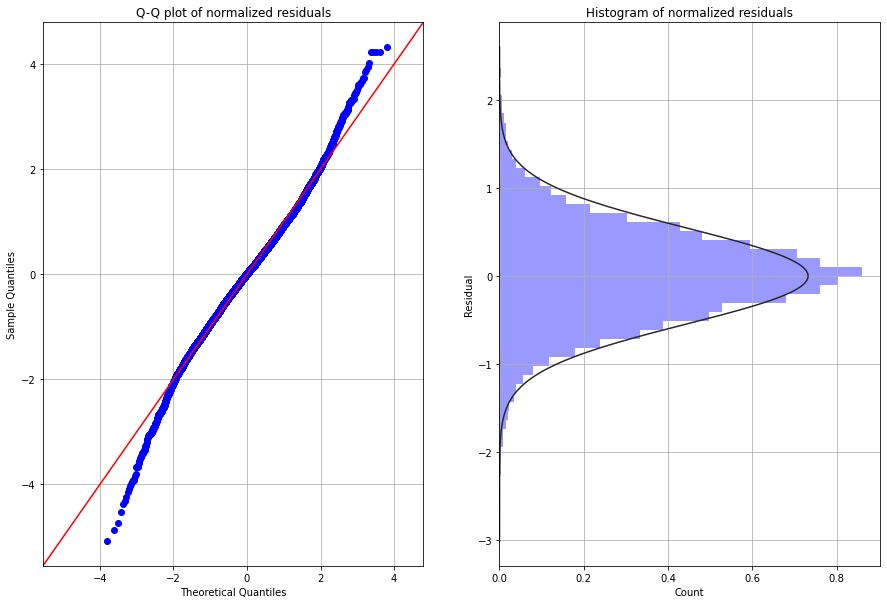

In [192]:
residuals = model9.resid
norm_dist_assumption(residuals)

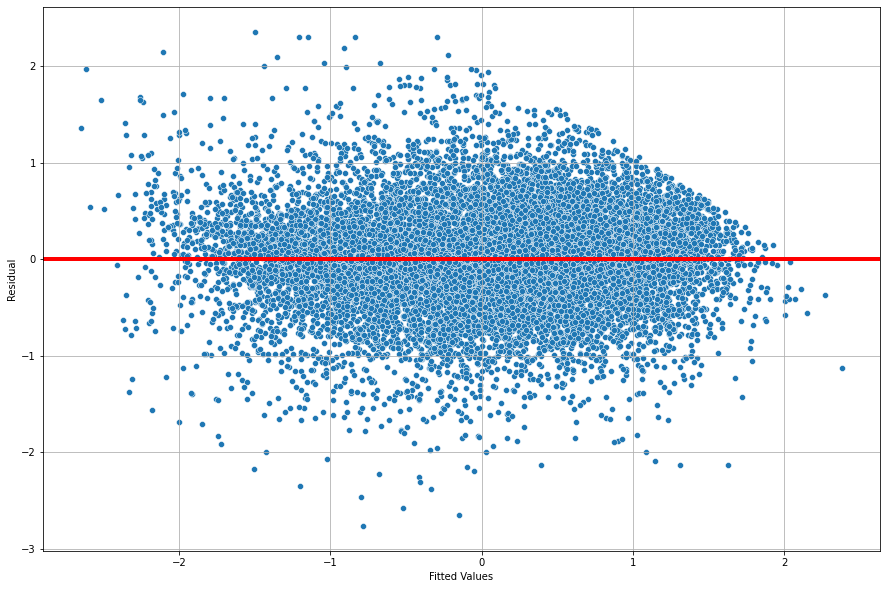

In [193]:
Heteroskedasticity_test(model9)

# Model 10 



In [194]:
target_var10 =['log_price','totalcrime_percapita_log','sqft_living_log','grade_6','grade_7','grade_rank_5','grade_rank_6','grade_rank_7','bins_walk_score_4_0']
df_model10= df_norm[target_var10]

In [195]:
df_model10.dropna(inplace=True)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [196]:
train, test = train_test_split(df_model10)
print(len(train), len(test))

13577 4526


In [197]:
outcome = 'log_price'
x_cols = list(df_model10.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model10 = ols(formula=formula, data=train).fit()
model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     3706.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:34:08   Log-Likelihood:                -11361.
No. Observations:               13577   AIC:                         2.274e+04
Df Residuals:                   13568   BIC:                         2.281e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0005      0.005      0.105      0.916      -0.009       0.010
totalcrime_percapita_log    -0.1268      0.005    -25.190      0.000      -0.137      -0.117
sqft_living_log              0.4955      0.006     83.664      0.000       0.484       0.507
grade_6                     -0.1217      0.006    -20.385      0.000      -0.133      -0.110
grade_7                     -0.1590      0.006    -28.257      0.000      -0.170      -0.148
grade_rank_5                -0.3244      0.005    -65.216      0.000      -0.334      -0.315
grade_rank_6                -0.1847      0.005    -36.592      0.000      -0.195      -0.175
grade_rank_7                -0.3452      0.005    -68.007      0.000      -0.355      -0.335
bins_walk_score_4_0          0.1207      0.005     23.640      0.000       0.111       0.131
==============================================================================
Omnibus:                      291.343   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              650.485
Skew:                           0.023   Prob(JB):                    5.61e-142
Kurtosis:                       4.071   Cond. No.                         2.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


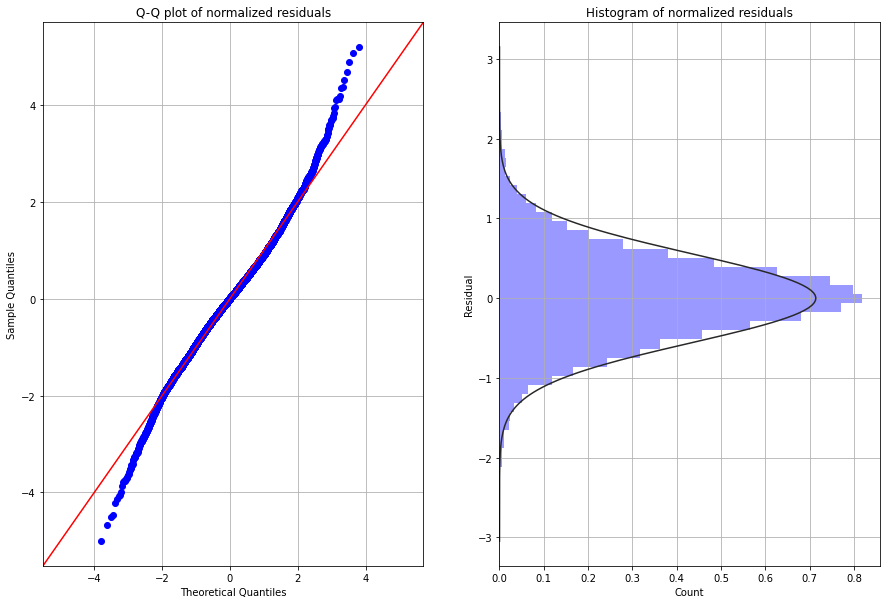

In [198]:
residuals = model10.resid
norm_dist_assumption(residuals)

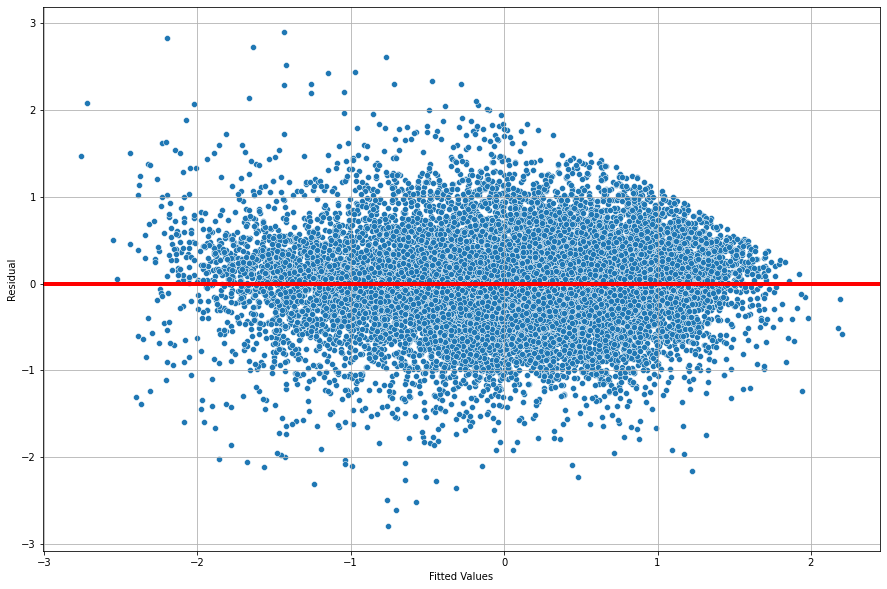

In [199]:
Heteroskedasticity_test(model10)

# Model 11 
Quantile transformation

In [201]:
df_quantile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 38 columns):
price                           18109 non-null float64
bathrooms                       18109 non-null float64
sqft_lot                        18109 non-null float64
sqft_living                     18109 non-null float64
School_K_12                     18109 non-null float64
School_Junior_High_Middle       18109 non-null float64
School_Elementary               18109 non-null float64
dist_School_High                18109 non-null float64
ef_School_Junior_High_Middle    18109 non-null float64
ef_dist_School_High             18109 non-null float64
ef_School_Elementary            18109 non-null float64
ef_School_K_12                  18109 non-null float64
transport_dist                  18109 non-null float64
medical_dist                    18109 non-null float64
police_station_dist             18109 non-null float64
School_dist_avg                 18109 non-null float64
ef_School_d

In [205]:
df_model11= df_quantile.drop(['School_Elementary','School_K_12','dist_School_High','School_Junior_High_Middle'], axis=1)

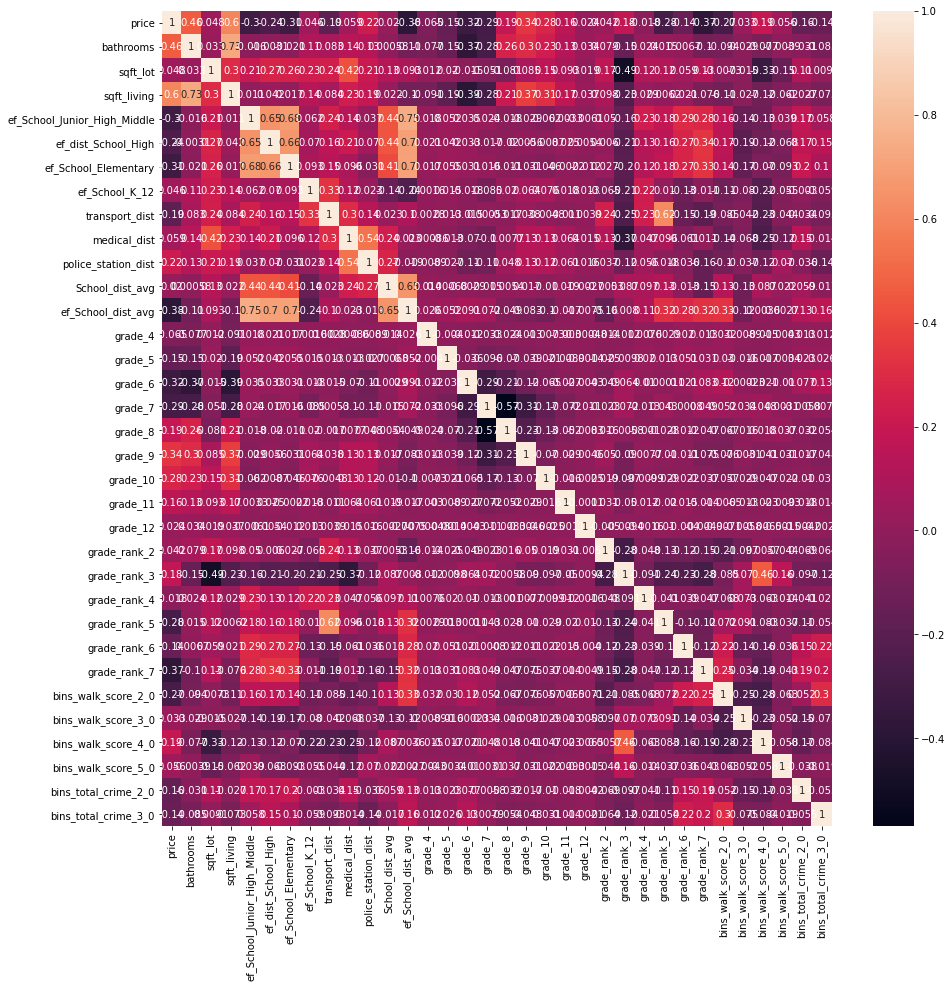

In [208]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model11.corr(),annot=True)

In [207]:
correlation(df_model11)

Empty DataFrame
Columns: [cc]
Index: []

In [209]:
train, test = train_test_split(df_model11)
print(len(train), len(test))

13581 4528


In [210]:
outcome = 'price'
x_cols = list(df_model11.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model11 = ols(formula=formula, data=train).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1149.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:42:32   Log-Likelihood:                -10279.
No. Observations:               13581   AIC:                         2.063e+04
Df Residuals:                   13547   BIC:                         2.088e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -5.5417      1.829     -3.030      0.002      -9.126      -1.957
bathrooms                       -0.0015      0.007     -0.200      0.841      -0.016       0.013
sqft_lot                         0.1173      0.006     19.208      0.000       0.105       0.129
sqft_living                      0.3987      0.008     49.755      0.000       0.383       0.414
ef_School_Junior_High_Middle     0.0517      0.008      6.131      0.000       0.035       0.068
ef_dist_School_High              0.0855      0.007     11.528      0.000       0.071       0.100
ef_School_Elementary            -0.0210      0.008     -2.750      0.006      -0.036      -0.006
ef_School_K_12                  -0.0332      0.003    -11.823      0.000      -0.039      -0.028
transport_dist                  -0.0163      0.004     -4.213      0.000      -0.024      -0.009
medical_dist                    -0.0662      0.007     -9.959      0.000      -0.079      -0.053
police_station_dist              0.0356      0.006      6.170      0.000       0.024       0.047
School_dist_avg                 -0.2562      0.023    -11.348      0.000      -0.300      -0.212
ef_School_dist_avg               0.2799      0.034      8.307      0.000       0.214       0.346
grade_4                         -0.1307      0.051     -2.561      0.010      -0.231      -0.031
grade_5                         -0.1334      0.050     -2.675      0.007      -0.231      -0.036
grade_6                         -0.1271      0.050     -2.553      0.011      -0.225      -0.030
grade_7                         -0.1080      0.050     -2.169      0.030      -0.206      -0.010
grade_8                         -0.0811      0.050     -1.628      0.103      -0.179       0.017
grade_9                         -0.0485      0.050     -0.974      0.330      -0.146       0.049
grade_10                        -0.0372      0.050     -0.746      0.456      -0.135       0.061
grade_11                         0.0096      0.050      0.191      0.849      -0.089       0.108
grade_12                        -0.0650      0.061     -1.065      0.287      -0.185       0.055
grade_rank_2                    -0.0839      0.003    -26.372      0.000      -0.090      -0.078
grade_rank_3                    -0.0533      0.004    -14.014      0.000      -0.061      -0.046
grade_rank_4                    -0.1176      0.006    -18.104      0.000      -0.130      -0.105
grade_rank_5                    -0.1827      0.007    -28.038      0.000      -0.196      -0.170
grade_rank_6                    -0.1645      0.007    -23.129      0.000      -0.178      -0.151
grade_rank_7                    -0.2054      0.008    -26.965      0.000      -0.220      -0.190
bins_walk_score_2_0              0.0016      0.001      1.114      0.265    

In [211]:
vif(train)

[('bathrooms', 2.4975445572207517),
 ('sqft_lot', 1.8956358022753221),
 ('sqft_living', 3.285693481469384),
 ('ef_School_Junior_High_Middle', 3.615570169961683),
 ('ef_dist_School_High', 2.833969546164296),
 ('ef_School_Elementary', 2.979556213810607),
 ('ef_School_K_12', 2.635735277465829),
 ('transport_dist', 4.665145105806442),
 ('medical_dist', 2.2544221696855007),
 ('police_station_dist', 1.6920634184008119),
 ('School_dist_avg', 25.572417025864848),
 ('ef_School_dist_avg', 57.79085352777304),
 ('grade_4', 188.66493134866738),
 ('grade_5', 75.07114352396574),
 ('grade_6', 60.941551498764056),
 ('grade_7', 58.04819198992092),
 ('grade_8', 57.6737149483737),
 ('grade_9', 58.370956445948615),
 ('grade_10', 61.354041170909404),
 ('grade_11', 86.26260707643719),
 ('grade_12', 1264.735944682399),
 ('grade_rank_2', 13.869215685014497),
 ('grade_rank_3', 19.820105669157588),
 ('grade_rank_4', 57.78410564568502),
 ('grade_rank_5', 57.996757750751506),
 ('grade_rank_6', 69.17755018814292),


In [212]:
residuals = model11.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


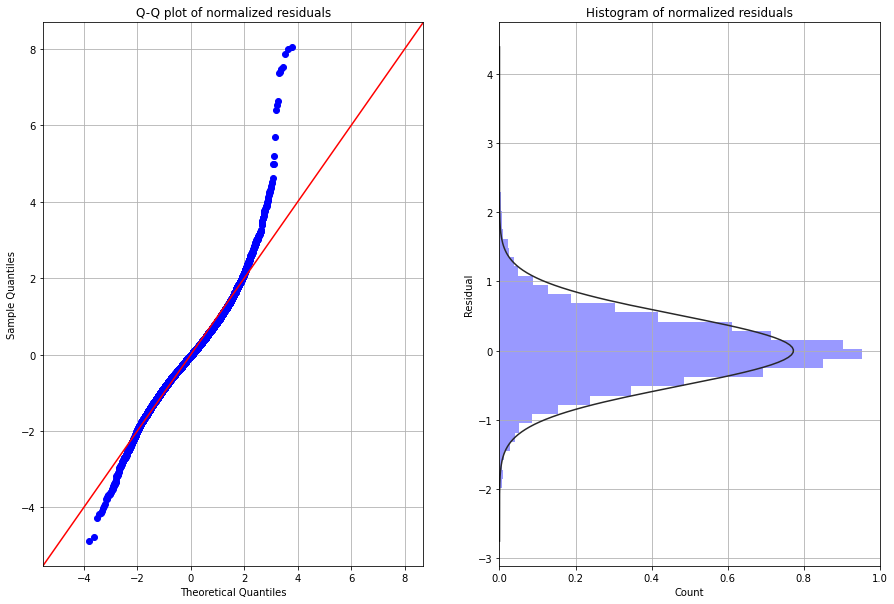

In [213]:
norm_dist_assumption(residuals)

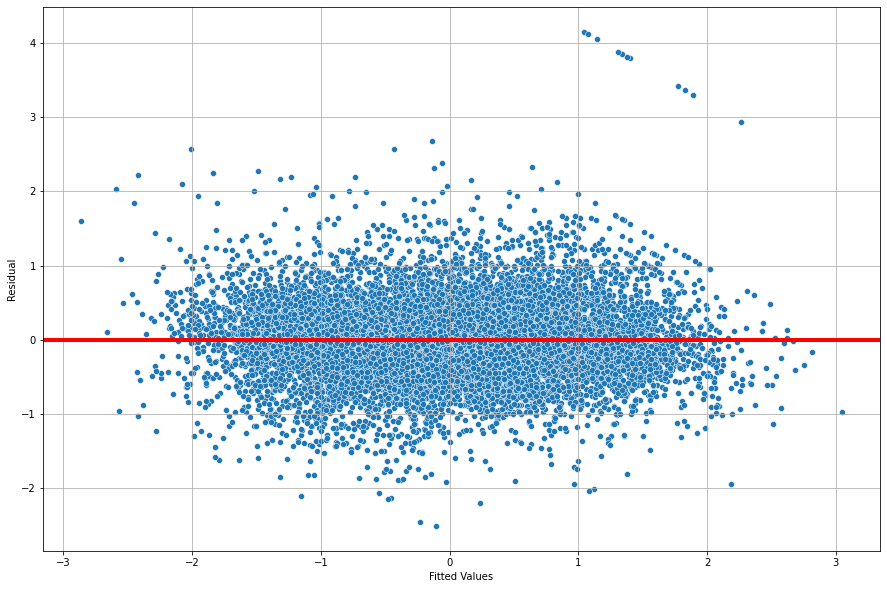

In [214]:
Heteroskedasticity_test(model11)

In [217]:
#Backward Elimination
y = df_model11['price']
cols = x_cols
X = df_model11[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['sqft_lot', 'sqft_living', 'ef_School_Junior_High_Middle', 'ef_dist_School_High', 'ef_School_Elementary', 'ef_School_K_12', 'transport_dist', 'medical_dist', 'police_station_dist', 'School_dist_avg', 'ef_School_dist_avg', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7', 'bins_walk_score_3_0', 'bins_walk_score_4_0', 'bins_walk_score_5_0', 'bins_total_crime_2_0', 'bins_total_crime_3_0']


In [218]:
predictors_be_11 = '+'.join(selected_features_BE_norm)
formula_be_11 = outcome + '~' + predictors_be_11
model_be_11 = ols(formula=formula_be_7, data=train).fit()
model_be_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1307.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:44:29   Log-Likelihood:                -10282.
No. Observations:               13581   AIC:                         2.062e+04
Df Residuals:                   13551   BIC:                         2.085e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -5.4496      0.203    -26.801      0.000      -5.848      -5.051
sqft_lot                         0.1174      0.006     20.113      0.000       0.106       0.129
sqft_living                      0.3976      0.007     60.503      0.000       0.385       0.410
ef_School_Junior_High_Middle     0.0515      0.008      6.114      0.000       0.035       0.068
ef_dist_School_High              0.0843      0.007     11.454      0.000       0.070       0.099
ef_School_Elementary            -0.0216      0.008     -2.851      0.004      -0.037      -0.007
ef_School_K_12                  -0.0334      0.003    -11.931      0.000      -0.039      -0.028
transport_dist                  -0.0164      0.004     -4.267      0.000      -0.024      -0.009
medical_dist                    -0.0678      0.006    -10.446      0.000      -0.081      -0.055
police_station_dist              0.0356      0.006      6.178      0.000       0.024       0.047
School_dist_avg                 -0.2520      0.022    -11.285      0.000      -0.296      -0.208
ef_School_dist_avg               0.2769      0.034      8.232      0.000       0.211       0.343
grade_4                         -0.1382      0.013    -10.776      0.000      -0.163      -0.113
grade_5                         -0.1414      0.007    -20.457      0.000      -0.155      -0.128
grade_6                         -0.1349      0.006    -23.646      0.000      -0.146      -0.124
grade_7                         -0.1159      0.005    -21.455      0.000      -0.126      -0.105
grade_8                         -0.0890      0.005    -16.702      0.000      -0.099      -0.079
grade_9                         -0.0565      0.005    -10.541      0.000      -0.067      -0.046
grade_10                        -0.0451      0.006     -8.022      0.000      -0.056      -0.034
grade_rank_2                    -0.0838      0.003    -26.355      0.000      -0.090      -0.078
grade_rank_3                    -0.0528      0.004    -13.966      0.000      -0.060      -0.045
grade_rank_4                    -0.1170      0.006    -18.066      0.000      -0.130      -0.104
grade_rank_5                    -0.1817      0.006    -28.157      0.000      -0.194      -0.169
grade_rank_6                    -0.1634      0.007    -23.158      0.000      -0.177      -0.150
grade_rank_7                    -0.2040      0.008    -27.077      0.000      -0.219      -0.189
bins_walk_score_3_0              0.0145      0.001     10.835      0.000       0.012       0.017
bins_walk_score_4_0              0.0367      0.001     25.738      0.000       0.034       0.039
bins_walk_score_5_0              0.0517      0.004     12.891      0.000       0.044       0.060
bins_total_crime_2_0            -0.0136      0.002     -8.370      0.000    

In [219]:
vif(train[selected_features_BE_norm])

[('sqft_lot', 1.7297727865703614),
 ('sqft_living', 2.1097350324848114),
 ('ef_School_Junior_High_Middle', 3.584450904655753),
 ('ef_dist_School_High', 2.7834606561866986),
 ('ef_School_Elementary', 2.9226637184621),
 ('ef_School_K_12', 2.5618759070070785),
 ('transport_dist', 4.582922649842709),
 ('medical_dist', 2.14203216344585),
 ('police_station_dist', 1.6878154631543487),
 ('School_dist_avg', 17.140169813791985),
 ('ef_School_dist_avg', 39.61115365472963),
 ('grade_4', 150.75408972896884),
 ('grade_5', 40.383287255171105),
 ('grade_6', 24.473789129838337),
 ('grade_7', 21.11943654628038),
 ('grade_8', 20.59569718885225),
 ('grade_9', 21.24667085110431),
 ('grade_10', 24.671442695424098),
 ('grade_rank_2', 9.559477885044116),
 ('grade_rank_3', 12.74840842683536),
 ('grade_rank_4', 39.677660576627105),
 ('grade_rank_5', 35.90010778290796),
 ('grade_rank_6', 43.545486467127475),
 ('grade_rank_7', 49.70452790130958),
 ('bins_walk_score_3_0', 2.4491605012969933),
 ('bins_walk_score_4_

# Model 12
Got the best features from the log transformation and tried them here

In [221]:
target_var12 =['price', 'ef_School_K_12','medical_dist','sqft_living','sqft_lot','grade_6','grade_7','grade_9','grade_rank_5','grade_rank_6','grade_rank_7','bins_walk_score_4_0']
df_model12= df_quantile[target_var12]

In [222]:
train, test = train_test_split(df_model12)
print(len(train), len(test))

13581 4528


In [223]:
outcome = 'price'
x_cols = list(df_model12.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model12 = ols(formula=formula, data=train).fit()
model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     2495.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:50:31   Log-Likelihood:                -11845.
No. Observations:               13581   AIC:                         2.371e+04
Df Residuals:                   13569   BIC:                         2.380e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1811      0.020    -59.561      0.000      -1.220      -1.142
ef_School_K_12         -0.0206      0.002     -9.416      0.000      -0.025      -0.016
medical_dist           -0.0571      0.006    -10.109      0.000      -0.068      -0.046
sqft_living             0.4773      0.007     72.809      0.000       0.464       0.490
sqft_lot                0.0675      0.006     11.085      0.000       0.056       0.079
grade_6                -0.0428      0.002    -21.464      0.000      -0.047      -0.039
grade_7                -0.0288      0.001    -24.501      0.000      -0.031      -0.027
grade_9                 0.0232      0.002     13.712      0.000       0.020       0.026
grade_rank_5           -0.1095      0.002    -64.140      0.000      -0.113      -0.106
grade_rank_6           -0.0749      0.002    -42.253      0.000      -0.078      -0.071
grade_rank_7           -0.1052      0.002    -68.161      0.000      -0.108      -0.102
bins_walk_score_4_0     0.0293      0.001     21.691      0.000       0.027       0.032
==============================================================================
Omnibus:                     1341.051   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5208.494
Skew:                           0.445   Prob(JB):                         0.00
Kurtosis:                       5.900   Cond. No.                         41.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
vif(train)

[('ef_School_K_12', 1.2856452982794895),
 ('medical_dist', 1.2857339224692812),
 ('sqft_living', 1.6989760142136314),
 ('sqft_lot', 1.4670522082244863),
 ('grade_6', 3.4876649486258517),
 ('grade_7', 1.395275611115519),
 ('grade_9', 2.5812346057620417),
 ('grade_rank_5', 2.4369894239713723),
 ('grade_rank_6', 2.489353258696067),
 ('grade_rank_7', 2.0187806203139025),
 ('bins_walk_score_4_0', 1.6836460451735937)]

In [225]:
residuals = model12.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


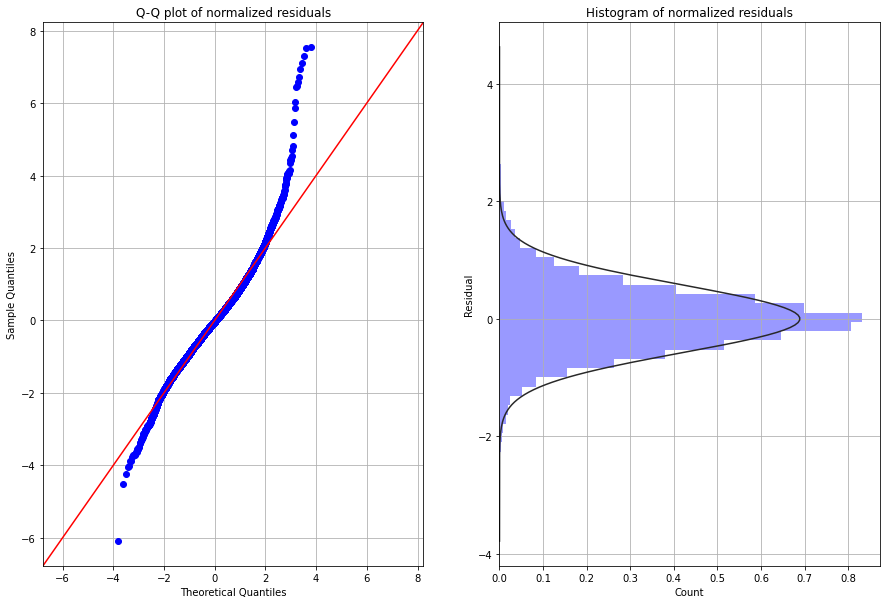

In [226]:
norm_dist_assumption(residuals)

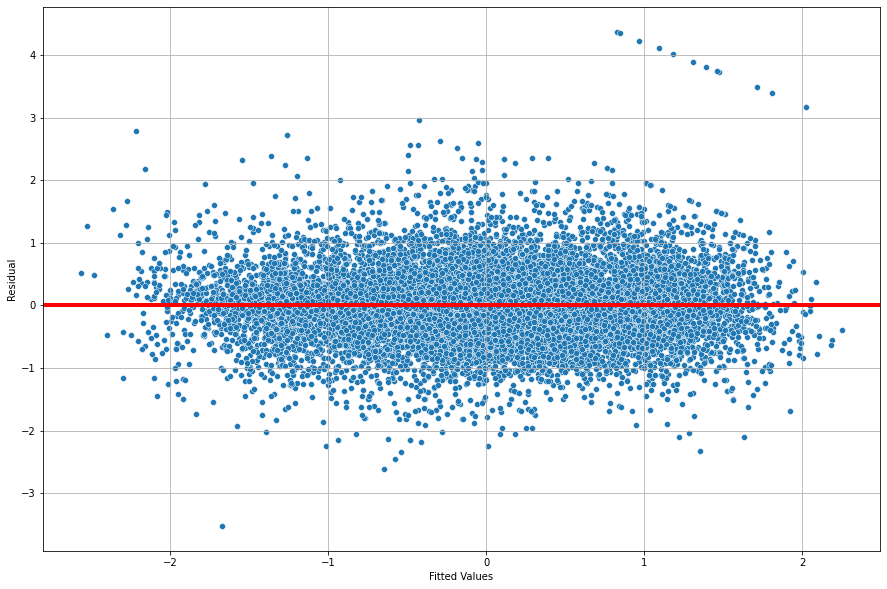

In [227]:
Heteroskedasticity_test(model12)

In [228]:
#Backward Elimination
y = df_model12['price']
cols = x_cols
X = df_model12[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12', 'medical_dist', 'sqft_living', 'sqft_lot', 'grade_6', 'grade_7', 'grade_9', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7', 'bins_walk_score_4_0']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [230]:
predictors_be_12 = '+'.join(selected_features_BE_norm)
formula_be_12 = outcome + '~' + predictors_be_12
model_be_12 = ols(formula=formula_be_12, data=train).fit()
model_be_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     2495.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:52:06   Log-Likelihood:                -11845.
No. Observations:               13581   AIC:                         2.371e+04
Df Residuals:                   13569   BIC:                         2.380e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1811      0.020    -59.561      0.000      -1.220      -1.142
ef_School_K_12         -0.0206      0.002     -9.416      0.000      -0.025      -0.016
medical_dist           -0.0571      0.006    -10.109      0.000      -0.068      -0.046
sqft_living             0.4773      0.007     72.809      0.000       0.464       0.490
sqft_lot                0.0675      0.006     11.085      0.000       0.056       0.079
grade_6                -0.0428      0.002    -21.464      0.000      -0.047      -0.039
grade_7                -0.0288      0.001    -24.501      0.000      -0.031      -0.027
grade_9                 0.0232      0.002     13.712      0.000       0.020       0.026
grade_rank_5           -0.1095      0.002    -64.140      0.000      -0.113      -0.106
grade_rank_6           -0.0749      0.002    -42.253      0.000      -0.078      -0.071
grade_rank_7           -0.1052      0.002    -68.161      0.000      -0.108      -0.102
bins_walk_score_4_0     0.0293      0.001     21.691      0.000       0.027       0.032
==============================================================================
Omnibus:                     1341.051   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5208.494
Skew:                           0.445   Prob(JB):                         0.00
Kurtosis:                       5.900   Cond. No.                         41.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
# From this I will remove grade 7, bathrooms
vif(train[selected_features_BE_norm])

[('ef_School_K_12', 1.2856452982794895),
 ('medical_dist', 1.2857339224692812),
 ('sqft_living', 1.6989760142136314),
 ('sqft_lot', 1.4670522082244863),
 ('grade_6', 3.4876649486258517),
 ('grade_7', 1.395275611115519),
 ('grade_9', 2.5812346057620417),
 ('grade_rank_5', 2.4369894239713723),
 ('grade_rank_6', 2.489353258696067),
 ('grade_rank_7', 2.0187806203139025),
 ('bins_walk_score_4_0', 1.6836460451735937)]

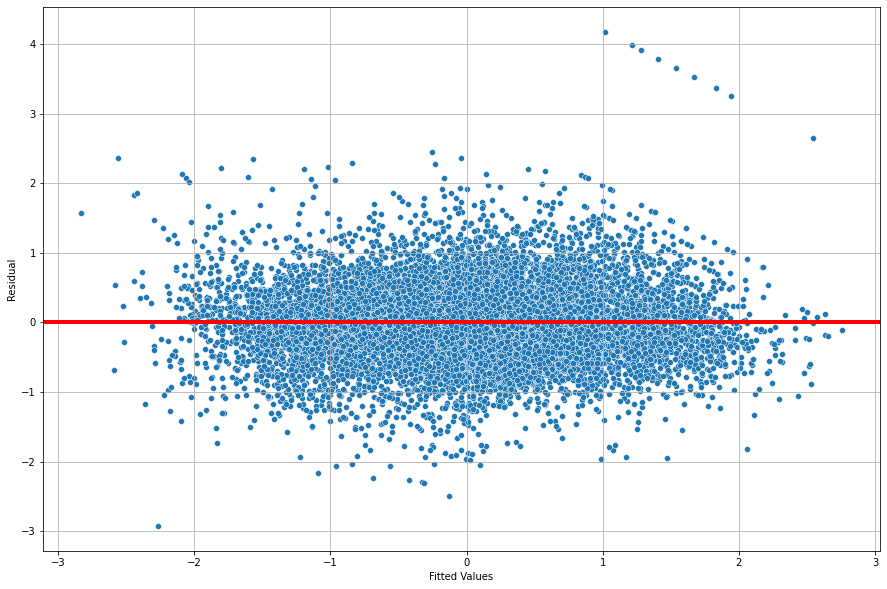

In [140]:
Heteroskedasticity_test(model8_m)